In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install captum
#!pip install transformers==3

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 42.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from sklearn import metrics
from copy import deepcopy
#from captum.attr import Saliency
from scipy.spatial.distance import hamming
from itertools import zip_longest
from time import perf_counter
import csv
import torch.nn as nn
import torch_geometric.nn as gnn
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor
from time import perf_counter
import random
import pandas
import statistics
from numpy import exp
import copy

In [3]:
from google.colab import drive
drive.mount('/content/drive')
from importlib import reload

Mounted at /content/drive


In [4]:
Explainability_name = 'SA'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
Model_name = "GCN_plus_GAP"
DataSet_name = "MUTAG"
normalize_coeff = 1
File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [5]:
print(File_Name)

GCN_plus_GAP SA Graph Classification MUTAG 


In [6]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [7]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [8]:
#print(read_training_list_indexes)
print(read_training_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]


In [9]:
torch.manual_seed(123456)
#dataset = dataset.shuffle()

#train_dataset = dataset[:150]
#test_dataset = dataset[150:]
train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
    train_dataset.append(dataset[index])
for index in read_test_list_indexes:
    test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


# **Batching Data by DataLoader**

In [10]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 64
size_of_hidden_layers = 7

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# **Model Designing**

In [11]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
import GCN_plus_GAP as Graph_Network
GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=7, hidden_dim=7, output_dim=2, num_hid_layers=2,
                                       Bias=classifier_bias, act_fun='ReLu', Weight_Initializer=1, dropout_rate=classifier_dropout)
#import DGCNN as dgcnn_model
#GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, mlp_act_fun='ReLu', dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=20, node_feat_size=7, hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])

GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
eLu is Selected.
GCN_plus_GAP(
  (GConvs): ModuleList(
    (0-1): 2 x GCNConv(7, 7)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=True)
)
GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
ReLu is Selected.


In [12]:
GNN_Model_optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [13]:
def twodim_tensor_converter(mylabels):
    new_labels = []
    for i in mylabels:
        new_labels.append(torch.stack([1 - i, i], dim=-1).to(torch.float32) )
    return torch.stack(new_labels)

In [14]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch

In [15]:
def loading_model(load_index):
    GNN_Model = Graph_Network.GCN_plus_GAP(hidden_channels=size_of_hidden_layers)
    #GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, mlp_act_fun='ReLu', dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=20, node_feat_size=7, hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])
    GNN_Model_optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)
    checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1) + ".pt")
    GNN_Model.load_state_dict(checkpoint['model_state_dict'])
    GNN_Model_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return GNN_Model, GNN_Model_optimizer, epoch

In [16]:
def visualize_losses(g_losses, epoch_history):
    g_losses_list = torch.stack(g_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("SA Model Loss in Epoch: " + str(epoch_history))

    ax.plot(g_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()




# **Traning Configurations**

In [17]:
def train_step():
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in train_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        batch_loss = loss_calculations(soft, batch_of_graphs.y)
        #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs)
        #batch_loss = loss_calculations(softmaxed_h2, batch_of_graphs.y)
        #print('passed')
        Pred_Labels.extend(soft.argmax(dim=1).detach().tolist())
        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)


In [18]:
Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [19]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

SA_Model_training_time_per_epoch = []
SA_Model_training_Acc_per_epoch = []

def train(EPOCHS, load_index):
    SA_training_loss_per_epoch = []

    for epoch in range(EPOCHS):

        start_generation = perf_counter()
        SA_model_training_loss, training_acc = train_step()
        SA_Model_training_time_per_epoch.append(perf_counter() - start_generation)
        SA_Model_training_Acc_per_epoch.append(training_acc)

        print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {SA_model_training_loss:.4f} Accuracy: {training_acc}')

        SA_training_loss_per_epoch.append(SA_model_training_loss)
        #break

        if (epoch + load_index + 1) % Visualization_Parameter == 0 and epoch > 0:
            visualize_losses(SA_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
            torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_optimizer.state_dict(), 'loss': SA_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")





Epoch: 001, SA Model Loss: 0.6995 Accuracy: 0.32666666666666666
Epoch: 002, SA Model Loss: 0.6978 Accuracy: 0.3333333333333333
Epoch: 003, SA Model Loss: 0.6970 Accuracy: 0.30666666666666664
Epoch: 004, SA Model Loss: 0.6954 Accuracy: 0.3466666666666667
Epoch: 005, SA Model Loss: 0.6943 Accuracy: 0.32
Epoch: 006, SA Model Loss: 0.6931 Accuracy: 0.5533333333333333
Epoch: 007, SA Model Loss: 0.6919 Accuracy: 0.6466666666666666
Epoch: 008, SA Model Loss: 0.6906 Accuracy: 0.6733333333333333
Epoch: 009, SA Model Loss: 0.6881 Accuracy: 0.6733333333333333
Epoch: 010, SA Model Loss: 0.6876 Accuracy: 0.6733333333333333
Epoch: 011, SA Model Loss: 0.6874 Accuracy: 0.6733333333333333
Epoch: 012, SA Model Loss: 0.6875 Accuracy: 0.6733333333333333
Epoch: 013, SA Model Loss: 0.6871 Accuracy: 0.6733333333333333
Epoch: 014, SA Model Loss: 0.6856 Accuracy: 0.6733333333333333
Epoch: 015, SA Model Loss: 0.6834 Accuracy: 0.6733333333333333
Epoch: 016, SA Model Loss: 0.6871 Accuracy: 0.6733333333333333
Epoc

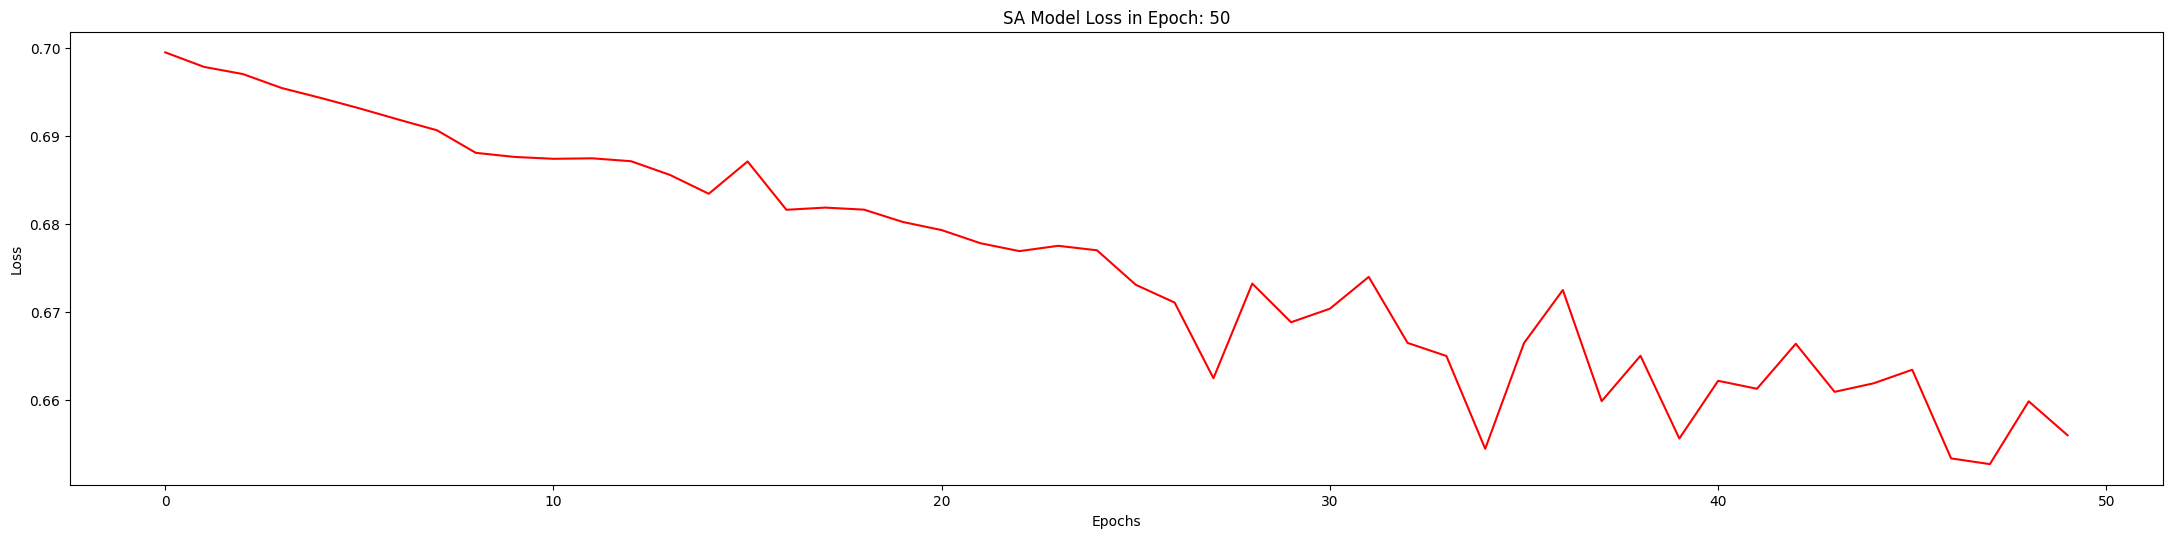

Epoch: 051, SA Model Loss: 0.6651 Accuracy: 0.6733333333333333
Epoch: 052, SA Model Loss: 0.6603 Accuracy: 0.6733333333333333
Epoch: 053, SA Model Loss: 0.6522 Accuracy: 0.6733333333333333
Epoch: 054, SA Model Loss: 0.6350 Accuracy: 0.6733333333333333
Epoch: 055, SA Model Loss: 0.6551 Accuracy: 0.6733333333333333
Epoch: 056, SA Model Loss: 0.6504 Accuracy: 0.6733333333333333
Epoch: 057, SA Model Loss: 0.6607 Accuracy: 0.6733333333333333
Epoch: 058, SA Model Loss: 0.6430 Accuracy: 0.6733333333333333
Epoch: 059, SA Model Loss: 0.6448 Accuracy: 0.6733333333333333
Epoch: 060, SA Model Loss: 0.6531 Accuracy: 0.6733333333333333
Epoch: 061, SA Model Loss: 0.6375 Accuracy: 0.6733333333333333
Epoch: 062, SA Model Loss: 0.6495 Accuracy: 0.6733333333333333
Epoch: 063, SA Model Loss: 0.6425 Accuracy: 0.6733333333333333
Epoch: 064, SA Model Loss: 0.6552 Accuracy: 0.6733333333333333
Epoch: 065, SA Model Loss: 0.6337 Accuracy: 0.6733333333333333
Epoch: 066, SA Model Loss: 0.6294 Accuracy: 0.673333333

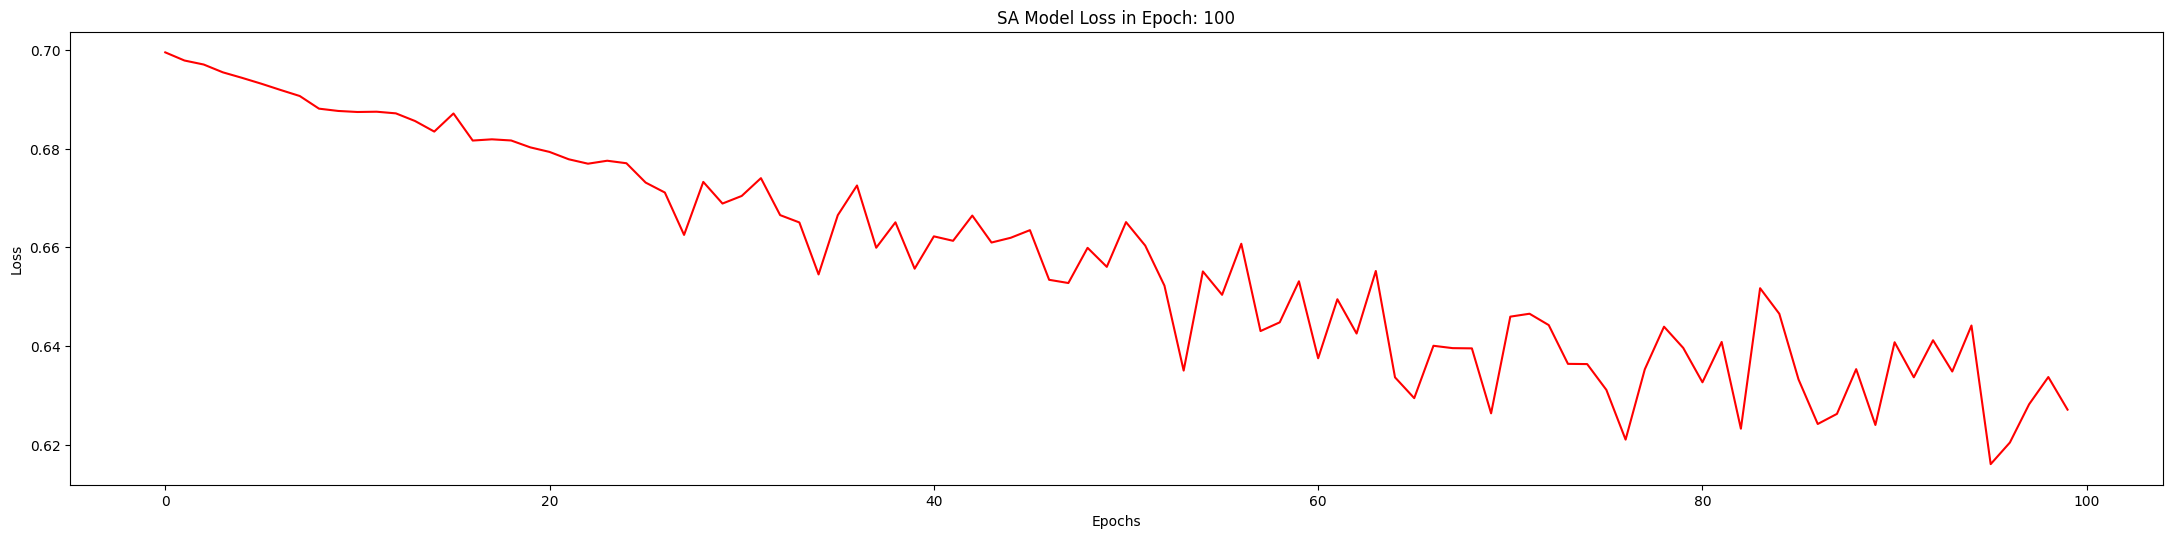

Epoch: 101, SA Model Loss: 0.6092 Accuracy: 0.6733333333333333
Epoch: 102, SA Model Loss: 0.6308 Accuracy: 0.6733333333333333
Epoch: 103, SA Model Loss: 0.6400 Accuracy: 0.6733333333333333
Epoch: 104, SA Model Loss: 0.6378 Accuracy: 0.6733333333333333
Epoch: 105, SA Model Loss: 0.6271 Accuracy: 0.6733333333333333
Epoch: 106, SA Model Loss: 0.6264 Accuracy: 0.6733333333333333
Epoch: 107, SA Model Loss: 0.6361 Accuracy: 0.6733333333333333
Epoch: 108, SA Model Loss: 0.6079 Accuracy: 0.6733333333333333
Epoch: 109, SA Model Loss: 0.6316 Accuracy: 0.6733333333333333
Epoch: 110, SA Model Loss: 0.6245 Accuracy: 0.6733333333333333
Epoch: 111, SA Model Loss: 0.6247 Accuracy: 0.6733333333333333
Epoch: 112, SA Model Loss: 0.6372 Accuracy: 0.6733333333333333
Epoch: 113, SA Model Loss: 0.6062 Accuracy: 0.6733333333333333
Epoch: 114, SA Model Loss: 0.6366 Accuracy: 0.6733333333333333
Epoch: 115, SA Model Loss: 0.6413 Accuracy: 0.6733333333333333
Epoch: 116, SA Model Loss: 0.5988 Accuracy: 0.673333333

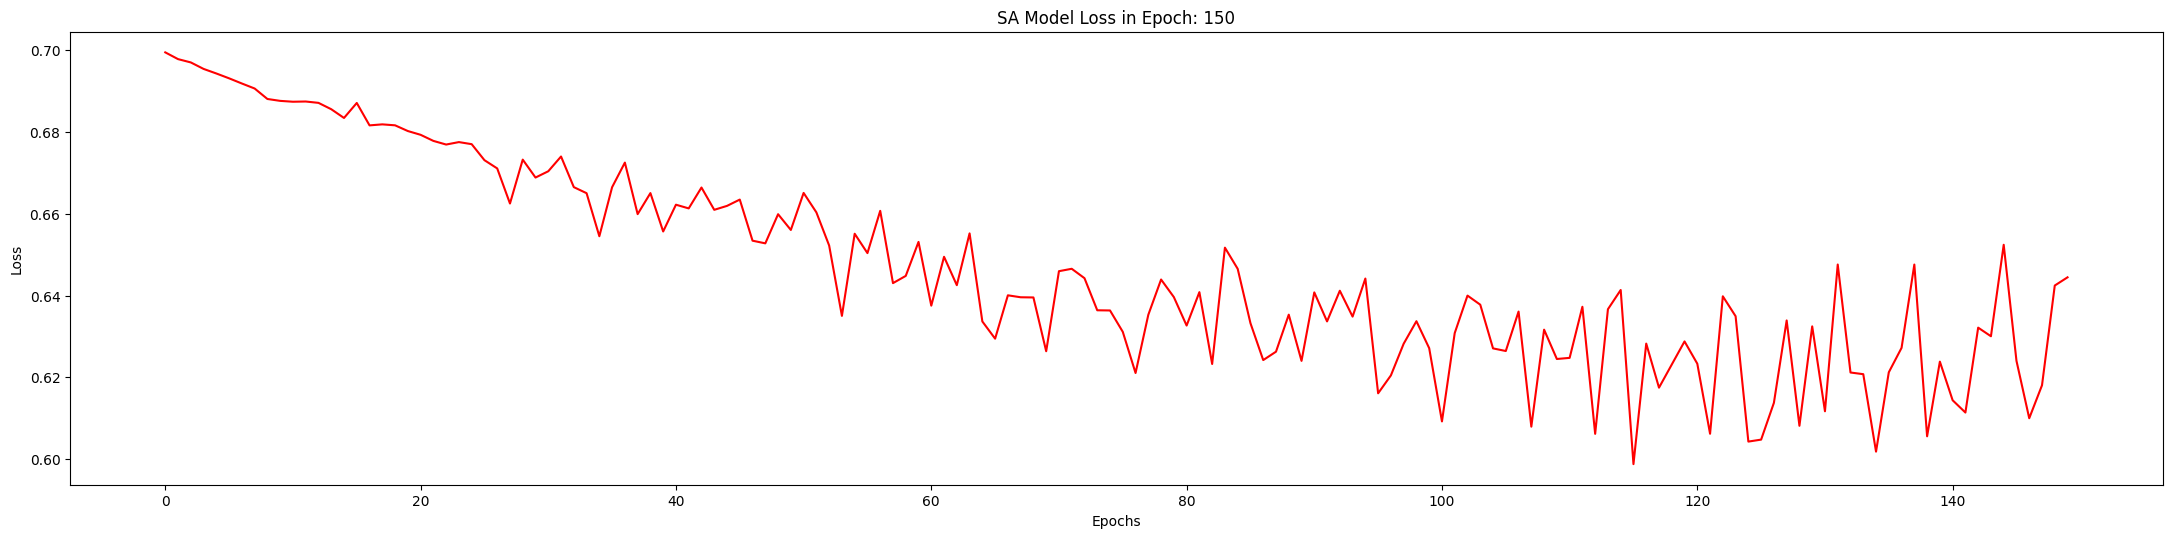

Epoch: 151, SA Model Loss: 0.6189 Accuracy: 0.6733333333333333
Epoch: 152, SA Model Loss: 0.6075 Accuracy: 0.6733333333333333
Epoch: 153, SA Model Loss: 0.6025 Accuracy: 0.6733333333333333
Epoch: 154, SA Model Loss: 0.6097 Accuracy: 0.6733333333333333
Epoch: 155, SA Model Loss: 0.5991 Accuracy: 0.6733333333333333
Epoch: 156, SA Model Loss: 0.6287 Accuracy: 0.6733333333333333
Epoch: 157, SA Model Loss: 0.6026 Accuracy: 0.6733333333333333
Epoch: 158, SA Model Loss: 0.6377 Accuracy: 0.6733333333333333
Epoch: 159, SA Model Loss: 0.6058 Accuracy: 0.6733333333333333
Epoch: 160, SA Model Loss: 0.6198 Accuracy: 0.6733333333333333
Epoch: 161, SA Model Loss: 0.6262 Accuracy: 0.6733333333333333
Epoch: 162, SA Model Loss: 0.6199 Accuracy: 0.6733333333333333
Epoch: 163, SA Model Loss: 0.6018 Accuracy: 0.6733333333333333
Epoch: 164, SA Model Loss: 0.6090 Accuracy: 0.6733333333333333
Epoch: 165, SA Model Loss: 0.6108 Accuracy: 0.6733333333333333
Epoch: 166, SA Model Loss: 0.6164 Accuracy: 0.673333333

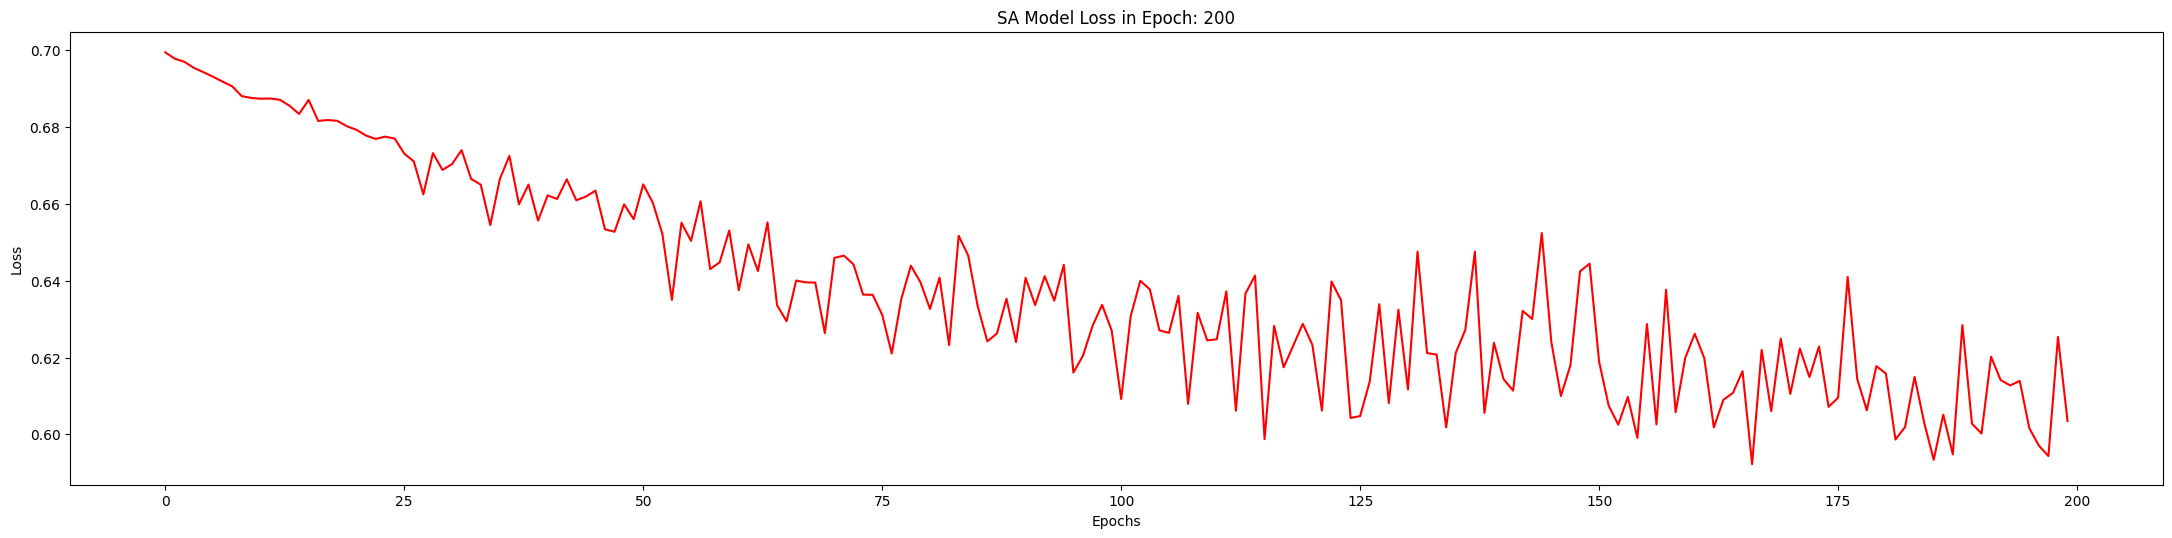

Epoch: 201, SA Model Loss: 0.6080 Accuracy: 0.6733333333333333
Epoch: 202, SA Model Loss: 0.5880 Accuracy: 0.6733333333333333
Epoch: 203, SA Model Loss: 0.6174 Accuracy: 0.6733333333333333
Epoch: 204, SA Model Loss: 0.5984 Accuracy: 0.6733333333333333
Epoch: 205, SA Model Loss: 0.6065 Accuracy: 0.6733333333333333
Epoch: 206, SA Model Loss: 0.6015 Accuracy: 0.6733333333333333
Epoch: 207, SA Model Loss: 0.6136 Accuracy: 0.6733333333333333
Epoch: 208, SA Model Loss: 0.5995 Accuracy: 0.6733333333333333
Epoch: 209, SA Model Loss: 0.6182 Accuracy: 0.6733333333333333
Epoch: 210, SA Model Loss: 0.6210 Accuracy: 0.6733333333333333
Epoch: 211, SA Model Loss: 0.6169 Accuracy: 0.6733333333333333
Epoch: 212, SA Model Loss: 0.5933 Accuracy: 0.6733333333333333
Epoch: 213, SA Model Loss: 0.5833 Accuracy: 0.6733333333333333
Epoch: 214, SA Model Loss: 0.6266 Accuracy: 0.6733333333333333
Epoch: 215, SA Model Loss: 0.5895 Accuracy: 0.6733333333333333
Epoch: 216, SA Model Loss: 0.6169 Accuracy: 0.673333333

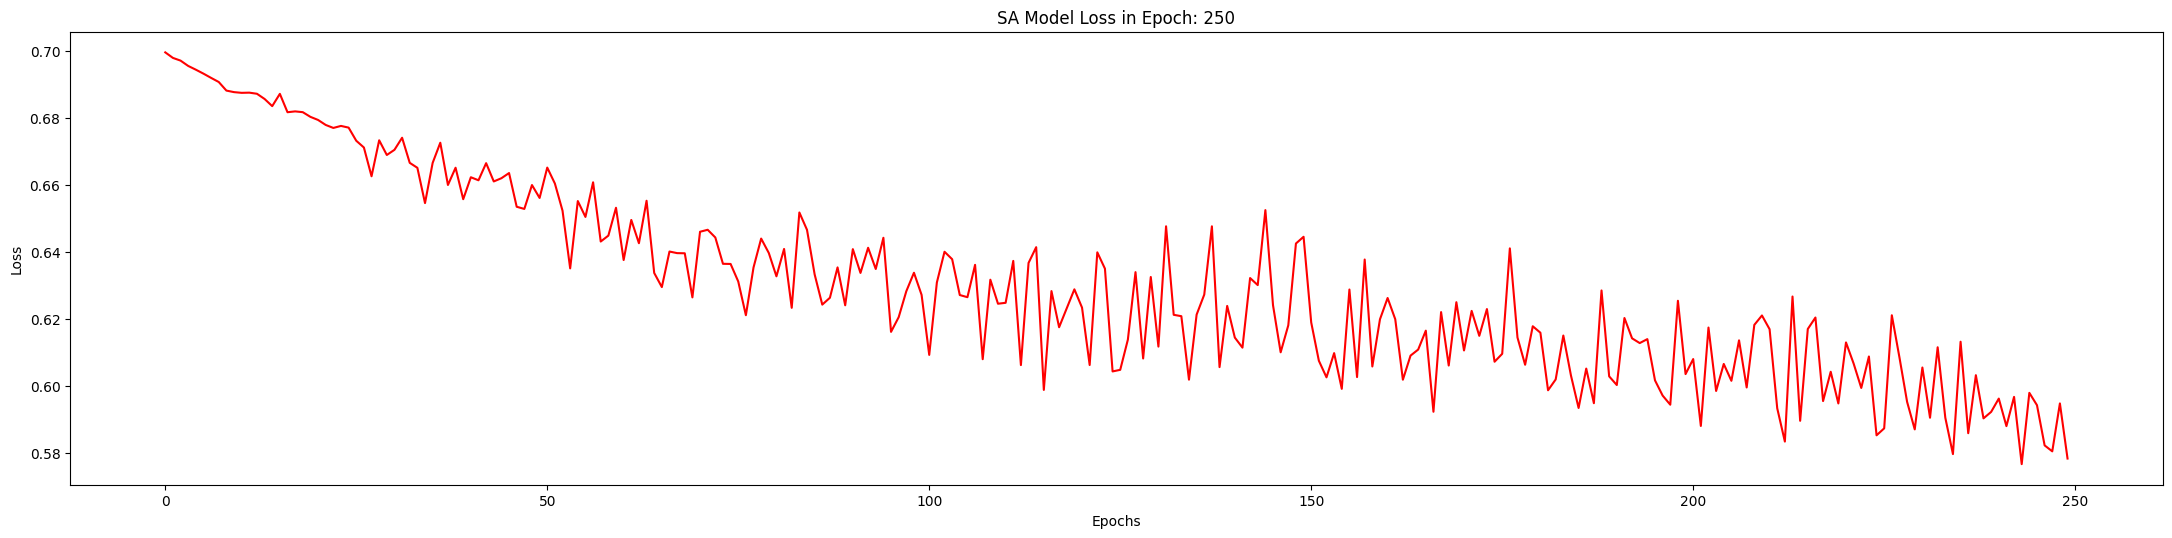

Epoch: 251, SA Model Loss: 0.5902 Accuracy: 0.6733333333333333
Epoch: 252, SA Model Loss: 0.5895 Accuracy: 0.6733333333333333
Epoch: 253, SA Model Loss: 0.6060 Accuracy: 0.6733333333333333
Epoch: 254, SA Model Loss: 0.5844 Accuracy: 0.6733333333333333
Epoch: 255, SA Model Loss: 0.5906 Accuracy: 0.6733333333333333
Epoch: 256, SA Model Loss: 0.5792 Accuracy: 0.6733333333333333
Epoch: 257, SA Model Loss: 0.5852 Accuracy: 0.6733333333333333
Epoch: 258, SA Model Loss: 0.5739 Accuracy: 0.68
Epoch: 259, SA Model Loss: 0.6034 Accuracy: 0.6733333333333333
Epoch: 260, SA Model Loss: 0.5825 Accuracy: 0.6733333333333333
Epoch: 261, SA Model Loss: 0.5971 Accuracy: 0.6733333333333333
Epoch: 262, SA Model Loss: 0.5801 Accuracy: 0.6733333333333333
Epoch: 263, SA Model Loss: 0.5944 Accuracy: 0.6733333333333333
Epoch: 264, SA Model Loss: 0.5838 Accuracy: 0.6733333333333333
Epoch: 265, SA Model Loss: 0.5945 Accuracy: 0.6733333333333333
Epoch: 266, SA Model Loss: 0.5598 Accuracy: 0.6733333333333333
Epoch:

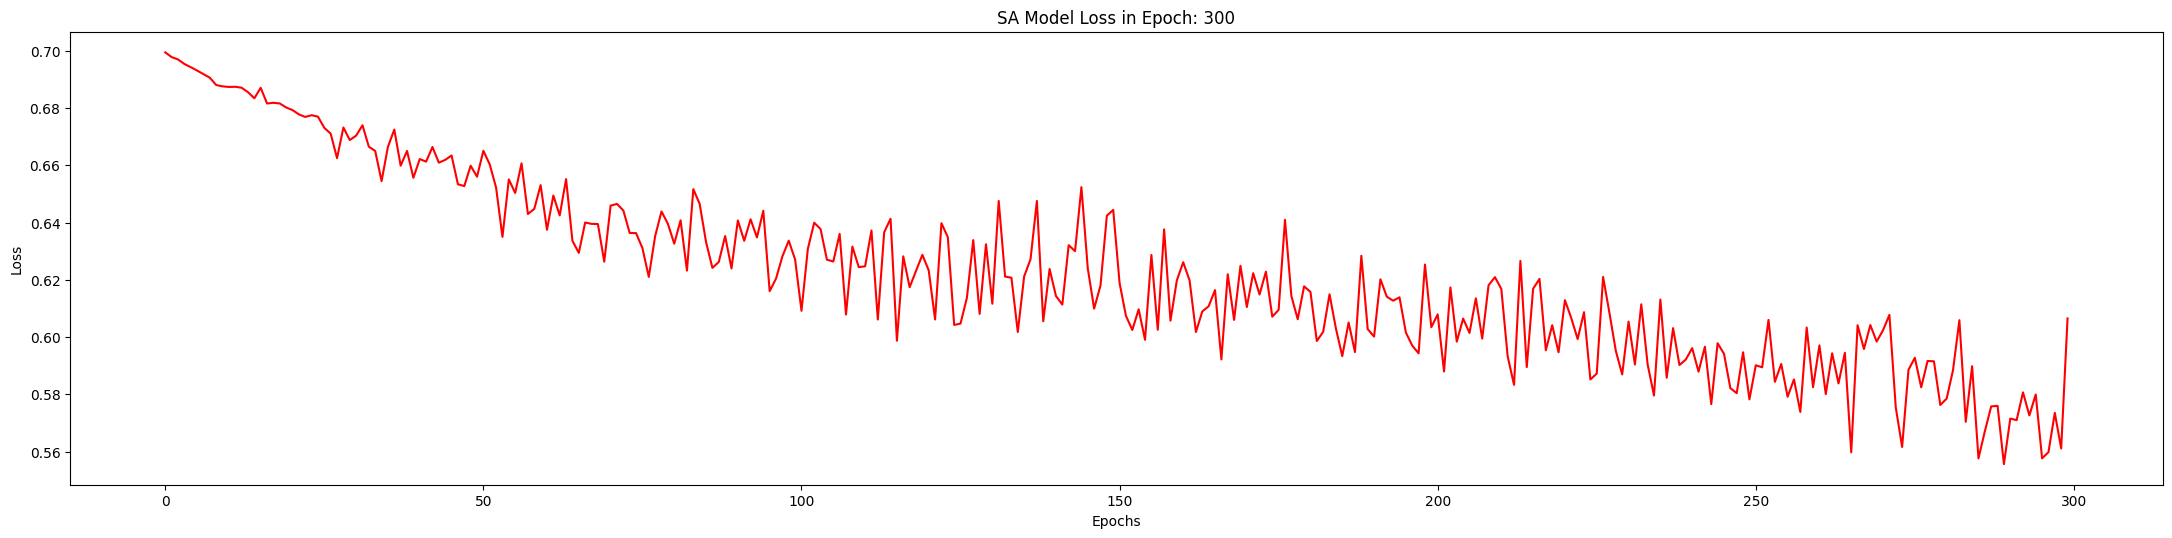

In [20]:
EPOCHS = 300
load_index = 0
if load_index != 0:
    model_GCN, optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [21]:
def GNN_Model_test(test_loader):
    predictions = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        SA_test_pred = soft.argmax(dim=1)
        #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batched_data)
        #SA_test_pred = softmaxed_h2.argmax(dim=1)
        predictions.extend(SA_test_pred.detach().tolist())
        correct += int((SA_test_pred == batched_data.y).sum())
    return correct / len(test_loader.dataset), predictions

In [22]:
SA_test_acc, predictions = GNN_Model_test(test_loader)
print(f'Test Accuracy: {SA_test_acc:.4f}')
print(predictions)

Test Accuracy: 0.6579
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


In [23]:
real_labels = []
for graph in test_dataset:
    real_labels.append(graph.y.detach().tolist()[0])
print(real_labels)

[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]


## **AUC-ROC & AUC-PRC & ACC**

In [24]:
Auc_Roc = metrics.roc_auc_score(real_labels, predictions)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predictions)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predictions, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predictions, normalize=False)
print("Auc_Roc: ", Auc_Roc, "Auc_Prc: ", Auc_Prc, "Acc: ", Acc, "Acc2: ", Acc2)

Auc_Roc:  0.5357142857142857 Auc_Prc:  0.8243243243243243 Acc:  0.6578947368421053 Acc2:  25


## **Instance Specific Time**

In [25]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        SA_test_pred = soft.argmax(dim=1)
        #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batched_data)
        #SA_test_pred = softmaxed_h2.argmax(dim=1)
        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [26]:
times = instance_time(test_loader)
print(f'Test Instance based Time: {mean(times)}')

Test Instance based Time: 0.0013948997631596165


# **SA**
# **Based on the Training Phase, for each of the Hidden Nodes in the hidden Layers, which Gradient is more important?**

# **Gradients of Test Samples with respect to each class**

In [27]:
def compute_grad(model, graph, with_respect):
    Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = model(graph)
    #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(graph)

    if with_respect == 1:
        loss = loss_calculations(soft, graph.y)
        #print(loss)
    elif with_respect == 2:
        loss = loss_calculations(soft, torch.tensor([0]))
        #print(loss)
    elif with_respect == 3:
        loss = loss_calculations(soft, torch.tensor([1]))
        #print(loss)
    GNN_Model_optimizer.zero_grad()
    return torch.autograd.grad(loss, list(GNN_Model.parameters()), allow_unused=True)

In [28]:
def remove_nones(sample_grads):
    sample_grads2 = []
    for item in sample_grads:
        Each_Graph = []
        for item2 in item:
            if item2 != None:
                Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True), requires_grad=True))
            else:
                Each_Graph.append(torch.tensor(0))
        sample_grads2.append(Each_Graph)
    return sample_grads2

In [29]:
def compute_sample_grads(model, test_dataset, with_respect):

    sample_grads = [compute_grad(model, graph, with_respect) for graph in test_loader]
    sample_grads = remove_nones(sample_grads)
    sample_grads = zip(*sample_grads)
    sample_grads = [torch.stack(shards) for shards in sample_grads]

    return sample_grads

In [30]:
per_sample_grads_wrt_class_one = compute_sample_grads(GNN_Model, test_dataset, 3)
per_sample_grads_wrt_class_zero = compute_sample_grads(GNN_Model, test_dataset, 2)
per_sample_grads_wrt_graph_label = compute_sample_grads(GNN_Model, test_dataset, 1)

<ipython-input-28-f215f2769853>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True), requires_grad=True))


In [31]:
print(len(per_sample_grads_wrt_class_zero))
print(per_sample_grads_wrt_class_zero[1].size())

6
torch.Size([38, 7, 7])


In [32]:
grads_wrt_graph_label = per_sample_grads_wrt_graph_label[1].detach().tolist()
grads_wrt_class_zero = per_sample_grads_wrt_class_zero[1].detach().tolist()
grads_wrt_class_one = per_sample_grads_wrt_class_one[1].detach().tolist()

In [33]:
print(np.shape(grads_wrt_graph_label))

(38, 7, 7)


In [ ]:
#print(per_sample_grads_wrt_graph_label, per_sample_grads_wrt_class_zero, per_sample_grads_wrt_class_one)
#print(per_sample_grads_wrt_graph_label[1])
#print(np.shape(grads_wrt_graph_label[1]), np.shape(grads_wrt_class_zero[0]), np.shape(grads_wrt_class_one[0]))

In [34]:
def column_wise_addups(gradients):
    return np.sum(gradients, axis=1).tolist()

In [35]:
def normalize_saliency(sal_maps):
    Graphs_new_gradients = []
    for graph_grads in sal_maps:
        new_gradients = []
        for node_grads in graph_grads:
            new_gradients.append(((node_grads-min(graph_grads)))/(max(graph_grads)-min(graph_grads)))
        Graphs_new_gradients.append(new_gradients)

    return Graphs_new_gradients

In [36]:
def compute_square_gradients(your_model, dataset):
    per_sample_grads_wrt_graph_label = compute_sample_grads(your_model, dataset, 1)
    per_sample_grads_wrt_class_zero = compute_sample_grads(your_model, dataset, 2)
    per_sample_grads_wrt_class_one = compute_sample_grads(your_model, dataset, 3)
    #print(np.shape(per_sample_grads_wrt_class_one[4]))
    #print(np.shape(per_sample_grads_wrt_class_one[5]))
    #print(np.shape(per_sample_grads_wrt_class_one[6]))
    #print(np.shape(per_sample_grads_wrt_class_one[7]))

    grads_wrt_graph_label = torch.square(per_sample_grads_wrt_graph_label[1])
    # square_grads_wrt_graph_label = torch.square(per_sample_grads_wrt_graph_label[1])
    square_grads_wrt_graph_label = grads_wrt_graph_label.detach().tolist()

    grads_wrt_class_zero = torch.square(per_sample_grads_wrt_class_zero[1])
    # square_grads_wrt_class_zero = torch.square(per_sample_grads_wrt_class_zero[1])
    square_grads_wrt_class_zero = grads_wrt_class_zero.detach().tolist()

    grads_wrt_class_one = torch.square(per_sample_grads_wrt_class_one[1])
    # square_grads_wrt_class_one = torch.square(per_sample_grads_wrt_class_one[1])
    square_grads_wrt_class_one = grads_wrt_class_one.detach().tolist()

    square_grads_wrt_graph_label = column_wise_addups(square_grads_wrt_graph_label)
    square_grads_wrt_class_zero = column_wise_addups(square_grads_wrt_class_zero)
    square_grads_wrt_class_one = column_wise_addups(square_grads_wrt_class_one)
    #print("square_grads_wrt_graph_label: ", square_grads_wrt_graph_label)
    #print("square_grads_wrt_class_zero: ", square_grads_wrt_class_zero)
    #print("square_grads_wrt_class_one: ", square_grads_wrt_class_one)
    #square_grads_wrt_graph_label = normalize_saliency(square_grads_wrt_graph_label)
    #square_grads_wrt_class_zero = normalize_saliency(square_grads_wrt_class_zero)
    #square_grads_wrt_class_one = normalize_saliency(square_grads_wrt_class_one)

    return square_grads_wrt_graph_label, square_grads_wrt_class_zero, square_grads_wrt_class_one

In [37]:
start_generation = perf_counter()
square_grads_wrt_graph_label, square_grads_wrt_class_zero, square_grads_wrt_class_one = compute_square_gradients(GNN_Model, test_dataset)
consumed_time = perf_counter() - start_generation
print(consumed_time/(3*len(test_dataset)))

<ipython-input-28-f215f2769853>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True), requires_grad=True))


0.004010061745614087


In [38]:
print("square_grads_wrt_graph_label", np.shape(square_grads_wrt_graph_label), square_grads_wrt_graph_label)

square_grads_wrt_graph_label (38, 7) [[0.03600074696699718, 2.8954599514463553e-05, 2.9634241684561857e-05, 0.0, 0.0, 0.0, 0.0], [0.7080296436556068, 0.012013909030429204, 0.0016329672871506773, 0.0, 0.0, 0.0, 0.0], [0.7132374657858804, 0.012421052228091867, 0.001653428924328182, 0.0, 0.0, 0.0, 0.0], [0.45293822334747347, 0.023684390673224698, 0.002470218292728532, 0.0, 0.0, 0.0, 0.0], [0.06364661365781643, 0.00019328026107245933, 4.134522032472887e-05, 0.0, 0.0, 0.0, 0.0], [0.08071385746135462, 7.949462815304287e-05, 8.136056135299441e-05, 0.00013696644327865215, 0.0, 0.0, 0.0], [0.07981008906792653, 0.0001885703188690968, 0.00020771500476257643, 0.0, 0.0, 0.0, 0.0], [0.21701140185469114, 0.0003285710645286599, 0.00035307370580994757, 0.0, 0.0, 0.0, 0.0], [0.027528894367686796, 2.904317113916477e-05, 2.9724887951942947e-05, 0.0, 0.0, 0.0, 0.0], [0.23566492062604993, 0.00026012307466771745, 0.0002662287561179255, 0.0, 0.0, 0.0, 0.0], [0.28172039501487234, 0.006103991370764561, 0.006247

## **Saliencies for Evaluation**

In [39]:
start_time = perf_counter()
square_grads_wrt_graph_label, square_grads_wrt_class_zero, square_grads_wrt_class_one = compute_square_gradients(GNN_Model, test_dataset)
importance_levels_for_feature_of_nodes_zero = []
importance_levels_for_feature_of_nodes_zero_node_based = []
for grads, graphs in zip(square_grads_wrt_class_zero, test_dataset):
    temp = []
    temp2 = []
    for nodes in graphs.x:
        temp.append(np.multiply(nodes, grads).tolist())
        temp2.append(sum(np.multiply(nodes, grads).tolist()))
    importance_levels_for_feature_of_nodes_zero.append(temp)
    importance_levels_for_feature_of_nodes_zero_node_based.append(temp2)


importance_levels_for_feature_of_nodes_one = []
importance_levels_for_feature_of_nodes_one_node_based = []
for grads, graphs in zip(square_grads_wrt_class_one, test_dataset):
    temp = []
    temp2 = []
    for nodes in graphs.x:
        temp.append(np.multiply(nodes, grads).tolist())
        temp2.append(sum(np.multiply(nodes, grads).tolist()))
    importance_levels_for_feature_of_nodes_one.append(temp)
    importance_levels_for_feature_of_nodes_one_node_based.append(temp2)

importance_levels_for_feature_of_nodes_glabel = []
importance_levels_for_feature_of_nodes_glabel_node_based = []
for grads, graphs in zip(square_grads_wrt_graph_label, test_dataset):
    temp = []
    temp2 = []
    for nodes in graphs.x:
        temp.append(np.multiply(nodes, grads).tolist())
        temp2.append(sum(np.multiply(nodes, grads).tolist()))
    importance_levels_for_feature_of_nodes_glabel.append(temp)
    importance_levels_for_feature_of_nodes_glabel_node_based.append(temp2)
cosumed_time = perf_counter() - start_time
print("cosumed_time: ", cosumed_time/(3*len(test_dataset)))

<ipython-input-28-f215f2769853>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True), requires_grad=True))


cosumed_time:  0.006530761570175514


In [ ]:
#importance_levels_for_feature_of_nodes_glabel_node_based = normalize_saliency(importance_levels_for_feature_of_nodes_glabel_node_based)
#importance_levels_for_feature_of_nodes_zero_node_based = normalize_saliency(importance_levels_for_feature_of_nodes_zero_node_based)
#importance_levels_for_feature_of_nodes_one_node_based = normalize_saliency(importance_levels_for_feature_of_nodes_one_node_based)

In [40]:
print(importance_levels_for_feature_of_nodes_zero)

[[[0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19880863041459662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0001598973502723311, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.00016365053807021468, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.00016365053807021468, 0.0, 0.0, 0.0, 0.0]], [[0.7080296436556068, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.7080296436556068, 0.0, 0.0, 0.0,

In [41]:
print(importance_levels_for_feature_of_nodes_zero_node_based)
print(importance_levels_for_feature_of_nodes_one_node_based)

[[0.19880863041459662, 0.19880863041459662, 0.19880863041459662, 0.19880863041459662, 0.19880863041459662, 0.19880863041459662, 0.19880863041459662, 0.19880863041459662, 0.19880863041459662, 0.19880863041459662, 0.19880863041459662, 0.19880863041459662, 0.19880863041459662, 0.19880863041459662, 0.0001598973502723311, 0.00016365053807021468, 0.00016365053807021468], [0.7080296436556068, 0.7080296436556068, 0.7080296436556068, 0.7080296436556068, 0.7080296436556068, 0.7080296436556068, 0.012013909030429204, 0.7080296436556068, 0.7080296436556068, 0.7080296436556068, 0.012013909030429204, 0.0016329672871506773, 0.0016329672871506773], [0.7132374657858804, 0.7132374657858804, 0.7132374657858804, 0.7132374657858804, 0.7132374657858804, 0.7132374657858804, 0.7132374657858804, 0.012421052228091867, 0.7132374657858804, 0.7132374657858804, 0.012421052228091867, 0.001653428924328182, 0.001653428924328182], [0.45293822334747347, 0.45293822334747347, 0.45293822334747347, 0.023684390673224698, 0.45

In [42]:
grads_wrt_graph_label = column_wise_addups(grads_wrt_graph_label)
grads_wrt_class_zero = column_wise_addups(grads_wrt_class_zero)
grads_wrt_class_one = column_wise_addups(grads_wrt_class_one)

In [43]:
print(np.shape(square_grads_wrt_graph_label))
print(square_grads_wrt_graph_label)
print(np.shape(grads_wrt_graph_label))

(38, 7)
[[0.03600074696699718, 2.8954599514463553e-05, 2.9634241684561857e-05, 0.0, 0.0, 0.0, 0.0], [0.7080296436556068, 0.012013909030429204, 0.0016329672871506773, 0.0, 0.0, 0.0, 0.0], [0.7132374657858804, 0.012421052228091867, 0.001653428924328182, 0.0, 0.0, 0.0, 0.0], [0.45293822334747347, 0.023684390673224698, 0.002470218292728532, 0.0, 0.0, 0.0, 0.0], [0.06364661365781643, 0.00019328026107245933, 4.134522032472887e-05, 0.0, 0.0, 0.0, 0.0], [0.08071385746135462, 7.949462815304287e-05, 8.136056135299441e-05, 0.00013696644327865215, 0.0, 0.0, 0.0], [0.07981008906792653, 0.0001885703188690968, 0.00020771500476257643, 0.0, 0.0, 0.0, 0.0], [0.21701140185469114, 0.0003285710645286599, 0.00035307370580994757, 0.0, 0.0, 0.0, 0.0], [0.027528894367686796, 2.904317113916477e-05, 2.9724887951942947e-05, 0.0, 0.0, 0.0, 0.0], [0.23566492062604993, 0.00026012307466771745, 0.0002662287561179255, 0.0, 0.0, 0.0, 0.0], [0.28172039501487234, 0.006103991370764561, 0.006247268305742182, 0.0, 0.0, 0.0, 

In [ ]:
#grads_wrt_graph_label = per_sample_grads_wrt_graph_label[1].detach().tolist()
#square_grads_wrt_graph_label = torch.square(per_sample_grads_wrt_graph_label[1])
#square_grads_wrt_graph_label = square_grads_wrt_graph_label.detach().tolist()

#grads_wrt_class_zero = per_sample_grads_wrt_class_zero[1].detach().tolist()
#square_grads_wrt_class_zero = torch.square(per_sample_grads_wrt_class_zero[1])
#square_grads_wrt_class_zero = square_grads_wrt_class_zero.detach().tolist()

#grads_wrt_class_one = per_sample_grads_wrt_class_one[1].detach().tolist()
#square_grads_wrt_class_one = torch.square(per_sample_grads_wrt_class_one[1])
#square_grads_wrt_class_one = square_grads_wrt_class_one.detach().tolist()

In [44]:
print(np.shape(square_grads_wrt_graph_label))
print(np.shape(square_grads_wrt_class_zero))
print(np.shape(square_grads_wrt_class_one))

(38, 7)
(38, 7)
(38, 7)


In [45]:
print("square_grads_wrt_graph_label: ", np.shape(square_grads_wrt_graph_label))

square_grads_wrt_graph_label:  (38, 7)


In [46]:
print(len(square_grads_wrt_graph_label[0]))

7


In [47]:
for i in range(len(square_grads_wrt_graph_label)):
    print("Graph Label: ", square_grads_wrt_graph_label[i], "Zero: ", square_grads_wrt_class_zero[i], "One: ", square_grads_wrt_class_one[i])

Graph Label:  [0.03600074696699718, 2.8954599514463553e-05, 2.9634241684561857e-05, 0.0, 0.0, 0.0, 0.0] Zero:  [0.19880863041459662, 0.0001598973502723311, 0.00016365053807021468, 0.0, 0.0, 0.0, 0.0] One:  [0.03600074696699718, 2.8954599514463553e-05, 2.9634241684561857e-05, 0.0, 0.0, 0.0, 0.0]
Graph Label:  [0.7080296436556068, 0.012013909030429204, 0.0016329672871506773, 0.0, 0.0, 0.0, 0.0] Zero:  [0.7080296436556068, 0.012013909030429204, 0.0016329672871506773, 0.0, 0.0, 0.0, 0.0] One:  [0.2502032945242263, 0.004245471459398686, 0.0005770573479821905, 0.0, 0.0, 0.0, 0.0]
Graph Label:  [0.7132374657858804, 0.012421052228091867, 0.001653428924328182, 0.0, 0.0, 0.0, 0.0] Zero:  [0.7132374657858804, 0.012421052228091867, 0.001653428924328182, 0.0, 0.0, 0.0, 0.0] One:  [0.25508481237964986, 0.004442311084858375, 0.000591338310186984, 0.0, 0.0, 0.0, 0.0]
Graph Label:  [0.45293822334747347, 0.023684390673224698, 0.002470218292728532, 0.0, 0.0, 0.0, 0.0] Zero:  [0.45293822334747347, 0.02368

## **Calculate Fiedelity**

In [ ]:
def Compute_ROC_AUC(your_model, your_dataset):
    preds = []
    reals = []

    your_model.eval()
    for batched_data in your_dataset:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, prediction = your_model(batched_data)

        preds.append(prediction.cpu().detach())

    for i in range(len(your_dataset)):
        reals.append(your_dataset[i].y.cpu().detach().tolist())
    #preds = torch.cat(preds).cpu().numpy()
    #preds = preds[:, 1]
    preds = torch.cat(preds)
    preds, max_idxs = torch.max(preds[:], dim=1)

    auc_roc = metrics.roc_auc_score(reals, preds, average='macro')
    return auc_roc

In [ ]:

auc_roc = Compute_ROC_AUC(GNN_Model, test_dataset)
print(auc_roc)


0.5833333333333333


In [ ]:
input = torch.randn(1, 10, requires_grad=True)
print(input)
torch.sum(input, dim=1).tolist()

tensor([[-0.1554,  0.7928,  1.0496,  1.0679, -1.3286, -0.6693, -2.3881,  1.0855,
          0.7881, -0.0772]], requires_grad=True)


[0.16528916358947754]

In [ ]:
def softmax(vector):
    e = exp(vector)
    return e / e.sum()

In [ ]:
def saliency(input_graphs, graphs_gradients):
    #gradients = self.softmax(gradients)
    Graphs_new_gradients = []
    for graph_grads in graphs_gradients:
        new_graphs = []
        for nodes in graph_grads:
            new_nodes = []
            for dim in nodes:
                new_nodes.append(((dim-min(nodes))*normalize_coeff)/(max(nodes)-min(nodes)))
            new_graphs.append(new_nodes)
        Graphs_new_gradients.append(new_graphs)
    #print(Graphs_new_gradients)

    #graphs_attributed_node_feat = []
    #for input_graph, g_grads in zip(input_graphs, Graphs_new_gradients):
    #    attributed_node_feat = []
    #    for node_feat in input_graph.x:
    #        attributed_node_feat.append(np.multiply(node_feat, g_grads).tolist())
    #    graphs_attributed_node_feat.append(attributed_node_feat)
    #print(graphs_attributed_node_feat)

    #graphs_attributed_nodes = []
    #for graph_atts in graphs_attributed_node_feat:
    #    attributed_nodes = []
    #    for node_feat in graph_atts:
    #        attributed_nodes.append(sum(node_feat))
    #    graphs_attributed_nodes.append(attributed_nodes)
    #print("graphs_attributed_nodes: ", graphs_attributed_nodes)

    #graph_nodes_importance_level = []
    #for graph_nodes in graphs_attributed_node_feat:
    #    nodes_importance_level = []
    #    for node_importance in graph_nodes:
    #        nodes_importance_level.append(node_importance/max(graph_nodes))
    #    graph_nodes_importance_level.append(nodes_importance_level)
    #print("graph_nodes_importance_level: ", graph_nodes_importance_level)

    return Graphs_new_gradients


In [ ]:
start_generation = perf_counter()
Sal = saliency(test_dataset, importance_levels_for_feature_of_nodes_glabel)
time_consumption = perf_counter() - start_generation

print(Sal)

0.00035732365789517404
[[[1.0, 0.0028167734789874546, 0.004414190118443573, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167734789874546, 0.004414190118443573, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167734789874546, 0.004414190118443573, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167734789874546, 0.004414190118443573, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167734789874546, 0.004414190118443573, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167734789874546, 0.004414190118443573, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167734789874546, 0.004414190118443573, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167734789874546, 0.004414190118443573, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167734789874546, 0.004414190118443573, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167734789874546, 0.004414190118443573, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167734789874546, 0.004414190118443573, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167734789874546, 0.004414190118443573, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167734789874546, 0.004414190118443573, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167734789874546, 0.00441419

In [ ]:
start_generation = perf_counter()
Sal_zero = saliency(test_dataset, importance_levels_for_feature_of_nodes_zero)
time_consumption = perf_counter() - start_generation
print(Sal_zero)

[[[1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731739257296, 0.00441418993916333, 0.0, 0.0, 0.0, 0.0], [1.0

In [ ]:
start_generation = perf_counter()
Sal_one = saliency(test_dataset, importance_levels_for_feature_of_nodes_one)
time_consumption = perf_counter() - start_generation
print(Sal_one)

[[[1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0], [1.0

In [ ]:
def saliency_time(dataset, grds):
    start_generation = perf_counter()
    Sal = saliency(dataset, importance_levels_for_feature_of_nodes_glabel)
    time_consumption = perf_counter() - start_generation
    return time_consumption

In [ ]:
print(saliency_time(test_dataset, square_grads_wrt_graph_label))

0.008612440999968385


In [ ]:
print(time_consumption)
print(len(Sal))
print(len(Sal[0]))
print(Sal[0][0])
print(Sal[0])

0.0006638229999680334
38
7
1.0
[1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0]


In [ ]:
print(len(Sal))
print(len(Sal[0]))
print(Sal[1])

38
7
[1.0, 0.05210568037492958, 0.030298747962516196, 0.0, 0.0, 0.0, 0.0]


In [ ]:
def is_salient(score, importance_threshold):
    if importance_threshold == score == 0:
        return True
    if importance_threshold == score == 1:
        return False
    if importance_threshold < score:
        return True
    else:
        return False

In [ ]:
def drop_important_nodes(your_dataset, importance_threshold, grads_first_layer):
    attribution_scores = saliency(your_dataset, grads_first_layer)
    # print(np.shape(attribution_scores), "attribution_scores: ", attribution_scores)
    # print("saliency passed")
    occluded_GNNgraph_list = []

    for i in range(len(attribution_scores)):
        sample_graph = deepcopy(your_dataset[i])
        for j in range(len(attribution_scores[i])):
            for k in range(len(attribution_scores[i][j])):
                if is_salient(attribution_scores[i][j][k], importance_threshold):
                    sample_graph.x[j][k] = 0
        occluded_GNNgraph_list.append(sample_graph)
    return occluded_GNNgraph_list

In [ ]:
threshold_check = 0.01
new_graph_dataset = drop_important_nodes(test_dataset, threshold_check, importance_levels_for_feature_of_nodes_glabel)

In [ ]:
print(new_graph_dataset)

[Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1]), Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1]), Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1]), Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1]), Data(edge_index=[2, 46], x=[20, 7], edge_attr=[46, 4], y=[1]), Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1]), Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1]), Data(edge_index=[2, 30], x=[14, 7], edge_attr=[30, 4], y=[1]), Data(edge_index=[2, 36], x=[17, 7], edge_attr=[36, 4], y=[1]), Data(edge_index=[2, 32], x=[15, 7], edge_attr=[32, 4], y=[1]), Data(edge_index=[2, 24], x=[12, 7], edge_attr=[24, 4], y=[1]), Data(edge_index=[2, 44], x=[21, 7], edge_attr=[44, 4], y=[1]), Data(edge_index=[2, 48], x=[23, 7], edge_attr=[48, 4], y=[1]), Data(edge_index=[2, 36], x=[16, 7], edge_attr=[36, 4], y=[1]), Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1]), Data(edge_index=[2, 20], x=[10, 7], edge_attr=[20, 4],

In [ ]:
print(len(new_graph_dataset))
print(len(new_graph_dataset[0].x))
for i, j, a in zip(new_graph_dataset, test_dataset, Sal):
    for k, l, b in zip(i.x, j.x, a):
        print(k, l, "---->", b)

38
17
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0]
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0]
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0]
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0]
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0]
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> [1.0, 0.0028167731297631914, 0.00441418981333347, 0.0, 0.0, 0.0, 0.0]
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> [1.0, 0.002816

In [ ]:
for i in range(len(test_dataset[0].x)):
    print(test_dataset[0].x[i], "------", new_graph_dataset[0].x[i])

tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 

In [ ]:
auc_roc1 = Compute_ROC_AUC(GNN_Model, test_dataset)
print(auc_roc1)

auc_roc2 = Compute_ROC_AUC(GNN_Model, new_graph_dataset)
print(auc_roc2)

0.5833333333333333
0.5416666666666666


In [ ]:
def Fidelity(your_model, your_dataset, feat_based_saliency_maps, importance_threshold):

    auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
    new_graph_dataset = drop_important_nodes(your_dataset, importance_threshold, feat_based_saliency_maps)
    auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

    return auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes

In [ ]:
fid_square_glabel_zero = Fidelity(GNN_Model, test_dataset, importance_levels_for_feature_of_nodes_zero, importance_threshold=0.01)
fid_square_glabel_one = Fidelity(GNN_Model, test_dataset, importance_levels_for_feature_of_nodes_one, importance_threshold=0.01)
print(fid_square_glabel_zero, fid_square_glabel_one)
print(mean([fid_square_glabel_zero, fid_square_glabel_one]))
#fid_square_class0 = Fidelity(SA_model_GCN, test_dataset, square_grads_wrt_class_zero, importance_range=(0.5, 1))
#print(fid_square_class0)
#fid_square_class1 = Fidelity(SA_model_GCN, test_dataset, square_grads_wrt_class_one, importance_range=(0.5, 1))
#print(fid_square_class1)

#fid = Fidelity(SA_model_GCN, test_dataset, grads_wrt_graph_label, importance_range=(0.5, 1))
#print(fid)
#fid = Fidelity(SA_model_GCN, test_dataset, grads_wrt_class_zero, importance_range=(0.5, 1))
#print(fid)
#fid = Fidelity(SA_model_GCN, test_dataset, grads_wrt_class_one, importance_range=(0.5, 1))
#print(fid)

0.04166666666666663 0.04166666666666663
0.04166666666666663


In [ ]:
class evalaution_of_xmethods_fidelity_plus(object):
    def __init__(self, model_name, a_trained_model, test_data):
        super(evalaution_of_xmethods_fidelity_plus, self).__init__()
        self.a_trained_model = a_trained_model
        self.test_data = test_data
        self.model_name = model_name


    def is_salient(self, score, importance_threshold):
        if importance_threshold == score == 0:
            return True
        if importance_threshold == score == 1:
            return False
        if importance_threshold < score:
            return True
        else:
            return False


    def Compute_ROC_AUC(self, your_model, your_dataset):
        preds = []
        reals = []

        your_model.eval()
        for batched_data in your_dataset:
            if self.model_name == "GCN_plus_GAP":
                Output_of_Hidden_Layers, pooling_layer_output, ffn_output, prediction = your_model(batched_data)
            else:
                print("Model Name is not valid.")

            preds.append(prediction.cpu().detach())

        for i in range(len(your_dataset)):
            reals.append(your_dataset[i].y.cpu().detach().tolist())

        preds = torch.cat(preds)
        preds, max_idxs = torch.max(preds[:], dim=1)

        auc_roc = metrics.roc_auc_score(reals, preds, average='macro')
        return auc_roc


    def drop_important_node_features(self, your_dataset, importance_threshold, saliency_maps):
        attribution_scores = saliency_maps
        occluded_GNNgraph_list = []

        for i in range(len(attribution_scores)):
            sample_graph = deepcopy(your_dataset[i])
            for j in range(len(attribution_scores[i])):
                for k in range(len(attribution_scores[i][j])):
                    if self.is_salient(attribution_scores[i][j][k], importance_threshold):
                        sample_graph.x[j][k] = 0
            occluded_GNNgraph_list.append(sample_graph)
        return occluded_GNNgraph_list

    def drop_important_nodes(self, your_dataset, importance_threshold, saliency_maps):
        attribution_scores = saliency_maps
        occluded_GNNgraph_list = []

        for i in range(len(attribution_scores)):
            sample_graph = deepcopy(your_dataset[i])
            for j in range(len(attribution_scores[i])):
                if self.is_salient(attribution_scores[i][j], importance_threshold):
                    sample_graph.x[j][:] = 0
            occluded_GNNgraph_list.append(sample_graph)
        return occluded_GNNgraph_list


    def Fidelity_node_features(self, your_dataset, generated_saliency_maps, importance_threshold):

        auc_roc_before_droping_important_nodes = self.Compute_ROC_AUC(self.a_trained_model, your_dataset)
        new_graph_dataset = self.drop_important_node_features(your_dataset, importance_threshold, generated_saliency_maps)
        auc_roc_after_droping_important_nodes = self.Compute_ROC_AUC(self.a_trained_model, new_graph_dataset)

        return auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes

    def Fidelity_node(self, your_dataset, generated_saliency_maps, importance_threshold):

        auc_roc_before_droping_important_nodes = self.Compute_ROC_AUC(self.a_trained_model, your_dataset)
        new_graph_dataset = self.drop_important_nodes(your_dataset, importance_threshold, generated_saliency_maps)
        auc_roc_after_droping_important_nodes = self.Compute_ROC_AUC(self.a_trained_model, new_graph_dataset)

        return auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes

    def normalize_saliency_node_features_based(self, sal_maps):
        Graphs_new_gradients = []
        for graph_grads in sal_maps:
            new_gradients = []
            for node_grads in graph_grads:
                node_gradients = []
                for dim in node_grads:
                    node_gradients.append((dim-min(node_grads))/(max(node_grads)-min(node_grads)))
                new_gradients.append(node_gradients)
            Graphs_new_gradients.append(new_gradients)

        return Graphs_new_gradients

    def normalize_saliency_node_based(self, sal_maps):
        Graphs_new_gradients = []
        for graph_grads in sal_maps:
            new_gradients = []
            for node_grads in graph_grads:
                new_gradients.append((node_grads-min(graph_grads))/(max(graph_grads)-min(graph_grads)))
            Graphs_new_gradients.append(new_gradients)

        return Graphs_new_gradients


    def my_fidelity(self, saliency_class0, saliency_class1, importance_threshold, style):
        if style == "Node Feature":
            try:
                saliency_class0 = self.normalize_saliency_node_features_based(saliency_class0)
                saliency_class1 = self.normalize_saliency_node_features_based(saliency_class1)

                fid_square_zero = self.Fidelity_node_features(self.test_data, saliency_class0, importance_threshold)
                fid_square_one = self.Fidelity_node_features(self.test_data, saliency_class1, importance_threshold)

                return mean([fid_square_zero, fid_square_one])
            except:
                print("attributions are not in appropriate shape")
        elif style == "Node":
            try:
                saliency_class0 = self.normalize_saliency_node_based(saliency_class0)
                saliency_class1 = self.normalize_saliency_node_based(saliency_class1)
                #print("saliency_class0: ",saliency_class0)
                #print("saliency_class1: ", saliency_class1)
                fid_square_zero = self.Fidelity_node(self.test_data, saliency_class0, importance_threshold)
                fid_square_one = self.Fidelity_node(self.test_data, saliency_class1, importance_threshold)
                return mean([fid_square_zero, fid_square_one])
            except:
                print("attributions are not in appropriate shape")
        else:
            print("node based not covered yet")




fid_xmethod_example = evalaution_of_xmethods_fidelity_plus(model_name="GCN_plus_GAP", a_trained_model=GNN_Model, test_data=test_dataset)
fid_score = fid_xmethod_example.my_fidelity(saliency_class0=importance_levels_for_feature_of_nodes_zero_node_based,
                                            saliency_class1=importance_levels_for_feature_of_nodes_one_node_based, importance_threshold=0.5,
                                            style="Node")
print("Fid_Score: ", fid_score)

Fid_Score:  0.19047619047619035


In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
eval_xai_fid_plus = reload(eval_xai_fid_plus)

In [ ]:
fid_xmethod_example_2 = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=GNN_Model,
                                                                               test_data=test_dataset)
fid_score2 = fid_xmethod_example_2.my_fidelity(saliency_class0=importance_levels_for_feature_of_nodes_zero_node_based,
                                               saliency_class1=importance_levels_for_feature_of_nodes_one_node_based,
                                               importance_threshold=0.5, style="Node")
print(fid_score2)

0.10416666666666674


## **Contrastivity**

In [ ]:
def normalize_for_contrastivity(sal_maps, contrast_coeff):
    final = []
    for graph in sal_maps:
        temp = []
        for node in graph:
            temp2 = []
            for score in node:
                if score != 1.0:
                    temp2.append(score*contrast_coeff - int(score*contrast_coeff))
                else:
                    temp2.append(score)
            temp.append(temp2)
        final.append(temp)
    return final


In [ ]:
def normalize_saliency(input_graphs, sal_maps):
    #gradients = self.softmax(gradients)
    Graphs_new_gradients = []
    for graph_grads in sal_maps:
        new_gradients = []
        for node_grads in graph_grads:
            node_gradients = []
            for dim in node_grads:
                node_gradients.append(((dim-min(node_grads))*normalize_coeff)/(max(node_grads)-min(node_grads)))
            new_gradients.append(node_gradients)
        Graphs_new_gradients.append(new_gradients)

    return Graphs_new_gradients

In [ ]:
def binarize_scores(your_dataset, saliency_maps, importance_threshold, contrast_coeff):

    attribution_scores = normalize_for_contrastivity(saliency_maps, contrast_coeff)
    attribution_scores = normalize_saliency(your_dataset, attribution_scores)

    binarized_attribution_scores_list = []
    for i in range(len(attribution_scores)):
        binary_score = ''
        sample_graph = deepcopy(your_dataset[i])
        for j in range(len(attribution_scores[i])):
            for k in range(len(attribution_scores[i][j])):
                if is_salient(attribution_scores[i][j][k], importance_threshold):
                    binary_score += '1'
                else:
                    binary_score += '0'
        binarized_attribution_scores_list.append(binary_score)
    return binarized_attribution_scores_list

In [ ]:
def hamming_distance(string1, string2):

    distance = 0
    L = len(string1)
    for i in range(L):
        if string1[i] != string2[i]:
            distance += 1
    return distance

In [ ]:
def compute_contrastivity(your_dataset, your_grads_class0, your_grads_class1, importance_range, contrast_coeff):
    binarized_salient_nodes_for_class0 = binarize_scores(your_dataset, your_grads_class0, importance_range, contrast_coeff)
    binarized_salient_nodes_for_class1 = binarize_scores(your_dataset, your_grads_class1, importance_range, contrast_coeff)
    #print("binarized_salient_nodes_for_class0: ", binarized_salient_nodes_for_class0)
    #print("binarized_salient_nodes_for_class1: ", binarized_salient_nodes_for_class1)

    result_list = []
    # Calculate hamming distance
    for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):
        #assert len(class_0) == len(class_1)
        d = hamming_distance(class_0, class_1)/len(class_0)
        result_list.append(d)

    return mean(result_list)


In [ ]:
attribution_scores_zero = normalize_for_contrastivity(Sal_zero, 1e+9)
attribution_scores_zero = saliency(test_dataset, attribution_scores_zero)

In [ ]:
attribution_scores_one = normalize_for_contrastivity(Sal_one, 1e+9)
attribution_scores_one = saliency(test_dataset, attribution_scores_one)

In [ ]:
#binarized_grads_graph = binarize_scores(test_dataset, grads_wrt_graph_label, importance_threshold=threshold_check)
threshold_check=0.5
binarized_grads_class_zero = binarize_scores(test_dataset, square_grads_wrt_class_zero, importance_threshold=threshold_check, contrast_coeff=10000000000)
binarized_grads_class_one = binarize_scores(test_dataset, square_grads_wrt_class_one, importance_threshold=threshold_check, contrast_coeff=10000000000)

In [ ]:
contrastivity_with_square = compute_contrastivity(test_dataset, importance_levels_for_feature_of_nodes_zero,
                                                  importance_levels_for_feature_of_nodes_one, importance_range=0.5,
                                                  contrast_coeff=1e+9)
print(contrastivity_with_square)

0.21804511278195488


In [ ]:
contrastivity_without_square = compute_contrastivity(test_dataset, grads_wrt_class_zero, grads_wrt_class_one, importance_range=x)

SA_attribution_scores:  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.9621155843560919, 0.9621155843560919], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8834908902465172, 0.0, 0.0, 0.0, 0.8834908902465172, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.88608779691962, 0.0, 0.0, 0.88608779691962, 1.0, 1.0], [0.0, 0.0, 0.0, 0.6528782966882787, 0.0, 0.6528782966882787, 0.0, 0.0, 0.0, 0.6528782966882787, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9369622824665373, 0.9369622824665373, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.9645896528118982, 0.9645896528118982, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9863179052951905], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.9359005977835114, 0.9359005977835114, 1.0, 0.9359005977835114, 0.9359005977835114], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.9485113118238482, 0.9485113118238482], [0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
print(contrastivity_with_square, contrastivity_without_square)

0.16079291326840936 0.8625423552308059


In [ ]:
class evalaution_of_xmethods_contrastivity(object):
    def __init__(self, model_name, a_trained_model, test_data):
        super(evalaution_of_xmethods_contrastivity, self).__init__()
        self.a_trained_model = a_trained_model
        self.test_data = test_data
        self.model_name = model_name


    def is_salient(self, score, importance_threshold):
        if importance_threshold == score == 0:
            return True
        if importance_threshold == score == 1:
            return False
        if importance_threshold < score:
            return True
        else:
            return False

    def standardize_for_contrastivity(self, sal_maps, contrast_coeff):
        final = []
        for graph in sal_maps:
            temp = []
            for node in graph:
                #temp2 = []
                #for score in node:
                if node != 1.0:
                    temp.append(node*contrast_coeff - int(node*contrast_coeff))
                else:
                    temp.append(node)
                #temp.append(temp2)
            final.append(temp)
        return final

    def normalize_saliency(self, input_graphs, sal_maps):
        Graphs_new_gradients = []
        for graph_grads in sal_maps:
            new_gradients = []
            for node_grads in graph_grads:
                #node_gradients = []
                #for dim in node_grads:
                    #node_gradients.append((dim-min(node_grads))/(max(node_grads)-min(node_grads)))
                new_gradients.append((node_grads-min(graph_grads))/(max(graph_grads)-min(graph_grads)))
            Graphs_new_gradients.append(new_gradients)

        return Graphs_new_gradients

    def binarize_scores(self, your_dataset, saliency_maps, importance_threshold, contrast_coeff):
        attribution_scores = self.standardize_for_contrastivity(saliency_maps, contrast_coeff)
        attribution_scores = self.normalize_saliency(your_dataset, attribution_scores)

        binarized_attribution_scores_list = []
        for i in range(len(attribution_scores)):
            binary_score = ''
            sample_graph = deepcopy(your_dataset[i])
            for j in range(len(attribution_scores[i])):
                #for k in range(len(attribution_scores[i][j])):
                if self.is_salient(attribution_scores[i][j], importance_threshold):
                    binary_score += '1'
                else:
                    binary_score += '0'
            binarized_attribution_scores_list.append(binary_score)
        return binarized_attribution_scores_list

    def hamming_distance(self, string1, string2):

        distance = 0
        L = len(string1)
        for i in range(L):
            if string1[i] != string2[i]:
                distance += 1
        return distance

    def my_contrastivity(self, your_dataset, for_zero, for_one, importance_threshold, contrast_coeff):
        try:
            binarized_salient_nodes_for_class0 = self.binarize_scores(your_dataset, for_zero, importance_threshold, contrast_coeff)
            binarized_salient_nodes_for_class1 = self.binarize_scores(your_dataset, for_one, importance_threshold, contrast_coeff)

            result_list = []
            for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):
                #print("class_0: ", class_0)
                #print("class_1: ", class_1)
                d = self.hamming_distance(class_0, class_1)/len(class_0)
                result_list.append(d)

            return mean(result_list)
        except:
            print("attributions are not in appropriate shape")



contrastivity_xmethod_example = evalaution_of_xmethods_contrastivity(model_name="GCN_plus_GAP", a_trained_model=GNN_Model,
                                                                     test_data=test_dataset)
contrastivity_score = contrastivity_xmethod_example.my_contrastivity(test_dataset, importance_levels_for_feature_of_nodes_zero_node_based,
                                                                     importance_levels_for_feature_of_nodes_one_node_based, importance_threshold=0.5,
                                                                     contrast_coeff=1e+4)
print("Contrastivity_Score: ", contrastivity_score)

Contrastivity_Score:  0.5214687669646277


In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
eval_xai_contrastivity = reload(eval_xai_contrastivity)

In [ ]:
contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(model_name="GCN_plus_GAP", a_trained_model=GNN_Model,
                                                                     test_data=test_dataset)
contrastivity_score = contrastivity_xmethod_example.my_contrastivity(test_dataset, importance_levels_for_feature_of_nodes_zero_node_based,
                                                                     importance_levels_for_feature_of_nodes_one_node_based, importance_threshold=0.5,
                                                                     contrast_coeff=1e+4)
print("Contrastivity_Score: ", contrastivity_score)

Contrastivity_Score:  0.5030305295467781


## **Sparsity**

In [ ]:
print(test_dataset[0].y[0].detach().tolist())

1


In [ ]:
norm_coeff = 1
def normalize_saliency(input_graphs, sal_maps):
    Graphs_new_gradients = []
    for graph_grads in sal_maps:
        new_gradients = []
        for node_grads in graph_grads:
            node_gradients = []
            for dim in node_grads:
                node_gradients.append(((dim-min(node_grads))*norm_coeff)/(max(node_grads)-min(node_grads)))
            new_gradients.append(node_gradients)
        Graphs_new_gradients.append(new_gradients)

    return Graphs_new_gradients

In [ ]:
def binarize_nodes(your_dataset, your_grads_class0, importance_threshold):
    attribution_scores_class0 = normalize_saliency(your_dataset, your_grads_class0)


    class_0_salient_nodes = []

    class_0_binarized = []
    for i in range(len(attribution_scores_class0)):
        sample_graph = deepcopy(your_dataset[i])
        class_0_graph = []
        for j in range(len(attribution_scores_class0[i])):
            node_0 = []
            for k in range(len(attribution_scores_class0[i][j])):
                if is_salient(attribution_scores_class0[i][j][k], importance_threshold):
                    node_0.append(1)
                else:
                    node_0.append(0)
            class_0_graph.append(node_0)
        class_0_binarized.append(class_0_graph)


    return class_0_binarized

In [ ]:
class_0_salient_nodes = binarize_nodes(test_dataset, importance_levels_for_feature_of_nodes_zero, importance_threshold=0.142856)
print(class_0_salient_nodes)

[[[1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0]], [[1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0]], [[1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0]], [[1,

In [ ]:
def count_important_nodes(salient_list):
    #print("salient_list: ", salient_list)
    summed = 0
    for sl in salient_list:
        summed = summed + sum(sl)
    return summed

In [ ]:
def compute_sparsity(your_dataset, your_grads_class0, your_grads_class1, importance_threshold):
    class_0_salient_nodes = binarize_nodes(your_dataset, your_grads_class0, importance_threshold)
    class_1_salient_nodes = binarize_nodes(your_dataset, your_grads_class1, importance_threshold)


    sparsity_list = []
    for i in range(len(your_grads_class0)):
        d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
        d = d / (len(your_grads_class0[i]) * 7)
        sparsity_list.append(1 - d)

    return mean(sparsity_list)

In [ ]:
sparsity = compute_sparsity(test_dataset, importance_levels_for_feature_of_nodes_zero, importance_levels_for_feature_of_nodes_one,
                            importance_threshold=0.01)
print(sparsity)

0.3759398496240602


In [ ]:
print(sparsity)

0.3759398496240602


In [ ]:
class evalaution_of_xmethods_sparsity(object):
    def __init__(self, model_name, a_trained_model, test_data):
        super(evalaution_of_xmethods_sparsity, self).__init__()
        self.a_trained_model = a_trained_model
        self.test_data = test_data
        self.model_name = model_name


    def is_salient(self, score, importance_threshold):
        if importance_threshold == score == 0:
            return True
        if importance_threshold == score == 1:
            return False
        if importance_threshold < score:
            return True
        else:
            return False

    def normalize_saliency(self, input_graphs, sal_maps):
        Graphs_new_gradients = []
        for graph_grads in sal_maps:
            new_gradients = []
            for node_grads in graph_grads:
                new_gradients.append((node_grads-min(graph_grads))/(max(graph_grads)-min(graph_grads)))
            Graphs_new_gradients.append(new_gradients)

        return Graphs_new_gradients

    def binarize_nodes(self, your_dataset, saliency_maps, importance_threshold):
        attribution_scores_class0 = self.normalize_saliency(your_dataset, saliency_maps)

        class_0_salient_nodes = []
        class_0_binarized = []
        for i in range(len(attribution_scores_class0)):
            sample_graph = deepcopy(your_dataset[i])
            class_0_graph = []
            for j in range(len(attribution_scores_class0[i])):
                if self.is_salient(attribution_scores_class0[i][j], importance_threshold):
                    class_0_graph.append(1)
                else:
                    class_0_graph.append(0)
            class_0_binarized.append(class_0_graph)


        return class_0_binarized

    def count_important_nodes(self, salient_list):

        #summed = 0
        #for sl in salient_list:
        #    summed = summed + sum(sl)
        #return summed
        return sum(salient_list)

    def my_sparsity(self, your_dataset, for_zero, for_one, importance_threshold):
        try:
            class_0_salient_nodes = self.binarize_nodes(your_dataset, for_zero, importance_threshold)
            class_1_salient_nodes = self.binarize_nodes(your_dataset, for_one, importance_threshold)

            sparsity_list = []
            for i in range(len(for_zero)):
                d = self.count_important_nodes(class_0_salient_nodes[i]) + self.count_important_nodes(class_1_salient_nodes[i])
                d = d / (len(for_zero[i]) * 2)
                sparsity_list.append(1 - d)

            return mean(sparsity_list)
        except:
            print("attributions are not in appropriate shape")


norm_coeff =1
contrastivity_xmethod_example = evalaution_of_xmethods_sparsity(model_name="GCN_plus_GAP", a_trained_model=GNN_Model,
                                                                test_data=test_dataset)
contrastivity_score = contrastivity_xmethod_example.my_sparsity(test_dataset, importance_levels_for_feature_of_nodes_zero_node_based,
                                                                importance_levels_for_feature_of_nodes_one_node_based,
                                                                importance_threshold=0.5)
print("Contrastivity_Score: ", contrastivity_score)

Contrastivity_Score:  0.3080612817386202


In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_sparsity as eval_xai_sparsity
eval_xai_sparsity = reload(eval_xai_sparsity)

In [ ]:
sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(model_name="GCN_plus_GAP", a_trained_model=GNN_Model,
                                                                     test_data=test_dataset)
sparsity_score = sparsity_xmethod_example.my_sparsity(test_dataset, importance_levels_for_feature_of_nodes_zero_node_based,
                                                                     importance_levels_for_feature_of_nodes_one_node_based, importance_threshold=0.5)
print("Sparsity_Score: ", sparsity_score)

Sparsity_Score:  0.3080612817386202


## **Get Metrics**

In [ ]:
import csv
#Header = np.array(["Explicability Method Name", "Task", "DataSet","Model", "AUC-ROC", "AUC-PRC", "Training Accuracy", "Test Accuracy", "Test Accuracy(count, TP+TN)", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time", "Avg. Training Time on 200 Epochs", "Instance Specific Time"])
#with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", 'w') as outcsv:
#    writer = csv.DictWriter(outcsv, fieldnames = Header)
#    writer.writeheader()

In [ ]:
def go_to_evaluations(your_model, dataset, importance_threshold):
    start_generation = perf_counter()
    square_grads_wrt_graph_label, square_grads_wrt_class_zero, square_grads_wrt_class_one = compute_square_gradients(your_model, dataset)
    time_consumption = perf_counter() - start_generation

    fid_square_glabel = Fidelity(your_model, dataset, square_grads_wrt_graph_label, importance_threshold)

    contrastivity_with_square = compute_contrastivity(dataset, square_grads_wrt_class_zero, square_grads_wrt_class_one, importance_threshold)

    sparsity_with_square = compute_sparsity(dataset, square_grads_wrt_graph_label, square_grads_wrt_class_zero, square_grads_wrt_class_one, importance_threshold)

    task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
    #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
    with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", 'a') as outcsv:
      wr = csv.writer(outcsv, dialect='excel', delimiter=',')
      wr.writerow([str(Explainability_name), task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, SA_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_square_glabel, contrastivity_with_square, sparsity_with_square, time_consumption, mean(SA_Model_training_time_per_epoch), times])

    return fid_square_glabel, contrastivity_with_square, sparsity_with_square, time_consumption/len(dataset)

In [ ]:
fid_square_glabel, contrastivity_with_square, sparsity_with_square, time_consumption = go_to_evaluations(GNN_Model, test_dataset, 0.00093102958)#0.142856)
print("fid_square_glabel: ", fid_square_glabel, "contrastivity_with_square: ", contrastivity_with_square, "sparsity_with_square: ", sparsity_with_square, "time_consumption: ", time_consumption)
#go_to_evaluations(GNN_Model, test_dataset, 0.142856)

<ipython-input-28-f215f2769853>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True), requires_grad=True))


SA_attribution_scores:  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0009310295768658655, 0.0012864834120745313, 0.0012864834120745313], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.019307140293709814, 1.0, 1.0, 1.0, 0.019307140293709814, 0.0025422881258667022, 0.0025422881258667022], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.02149592823130845, 1.0, 1.0, 0.02149592823130845, 0.00241624869370984, 0.00241624869370984], [1.0, 1.0, 1.0, 0.07855355905522954, 1.0, 0.07855355905522954, 1.0, 1.0, 1.0, 0.07855355905522954, 0.0056731824045581, 0.0056731824045581], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.004039926983762357, 0.004039926983762357, 0.0008787906749272968, 0.0008787906749272968], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0010372884934701223, 0.0013122464685897115, 0.0013122464685897115, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0010667679056064337], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.002254456443

In [ ]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv")
#print("here, ", df.loc[0, 'Explicability Method Name'])
df.loc[0, 'Fidelity'] = 0.029
df.loc[0, 'Contrastivity'] = 0.151
df.loc[0, 'Sparsity'] = 0.308
df.loc[0, 'Saliency Map Generation Time'] = 0.013
df.to_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", index=False)


# **Gradients of SA old way**

In [ ]:
print(binarized_grads_graph)
print(binarized_grads_class_zero)
print(binarized_grads_class_one)

['11111111111111111', '0000001000111', '0000000100111', '000101000111', '11111111111111111111', '11111111111111111', '1111111111111111111111', '00000000000111', '11111111111111111', '000000000000111', '111111111111', '111111111111111111111', '11111111111111111111111', '1111111111111111', '11111111111111111111111', '0000001111', '0000000000000111', '1111111111111111111111111', '1111111111111111', '11111111111111111111111', '0000100000111', '0000001000000111', '11111111111111111111111111', '11111111111111111', '111111111111111', '111111111111', '000000000000111111111', '0000000001000000111', '0110000000111', '1111111111111111', '1111111111111111', '001001001111', '111111111111', '000000111100', '11111111111111111111', '1111111111111', '1111111111111', '1111111111111111111111']
['00000000000000111', '0000001000111', '0000000100111', '000101000111', '00000000000000001111', '00000011100000001', '0000000000000000111111', '00000000000111', '00000000000000111', '000000000000111', '000000111111

In [ ]:

print(square_grads_wrt_class_zero)
print(square_grads_wrt_class_one)

[[0.001822863701818278, 1.6971400209880166e-06, 2.3450839148619895e-06, 0.0, 0.0, 0.0, 0.0], [4.038374550640583, 0.07796946400776505, 0.010266711667895834, 0.0, 0.0, 0.0, 0.0], [5.417984090745449, 0.11646459717303514, 0.013091196981804387, 0.0, 0.0, 0.0, 0.0], [0.18946755258366466, 0.01488335058093071, 0.0010748839855523329, 0.0, 0.0, 0.0, 0.0], [0.01970974530559033, 7.962593190313783e-05, 1.7320740379744848e-05, 0.0, 0.0, 0.0, 0.0], [1.0136894509196281, 0.0010514884033909766, 0.0013302104022159256, 0.0010813713724928675, 0.0, 0.0, 0.0], [0.016986992210149765, 3.829643404174021e-05, 6.147595168570774e-05, 0.0, 0.0, 0.0, 0.0], [0.004702963873569388, 6.6844271997545945e-06, 9.377181998226902e-06, 0.0, 0.0, 0.0, 0.0], [0.0018271192529937252, 1.7037456422766897e-06, 2.3423241700126773e-06, 0.0, 0.0, 0.0, 0.0], [0.003284280013758689, 4.086751664633681e-06, 5.556802021078333e-06, 0.0, 0.0, 0.0, 0.0], [4.418680965900421, 0.10561553272418678, 0.1328032662786427, 0.0, 0.0, 0.0, 0.0], [3.0866039

In [ ]:
binarized_square_grads_graph = binarize_scores(test_dataset, square_grads_wrt_graph_label, importance_threshold=0.5)
binarized_square_grads_class_zero = binarize_scores(test_dataset, square_grads_wrt_class_zero, importance_threshold=.5)
binarized_square_grads_class_one = binarize_scores(test_dataset, square_grads_wrt_class_one, importance_threshold=.5)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0009310295994680303, 0.0012864834439508138, 0.0012864834439508138], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.019307140293709814, 1.0, 1.0, 1.0, 0.019307140293709814, 0.0025422881258667022, 0.0025422881258667022], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.02149592823130845, 1.0, 1.0, 0.02149592823130845, 0.00241624869370984, 0.00241624869370984], [1.0, 1.0, 1.0, 0.07855355905522954, 1.0, 0.07855355905522954, 1.0, 1.0, 1.0, 0.07855355905522954, 0.0056731824045581, 0.0056731824045581], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0040399299909461535, 0.0040399299909461535, 0.0008787921566038685, 0.0008787921566038685], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.001037288533046144, 0.0013122466375551256, 0.0013122466375551256, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.001066767863705061], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.002254456633110854, 0.00361900164849

In [ ]:
print(binarized_square_grads_graph)
print(binarized_square_grads_class_zero)
print(binarized_square_grads_class_one)

['11111111111111000', '1111110111000', '1111111011000', '111010111000', '11111111111111110000', '11111100011111110', '1111111111111111000000', '11111111111000', '11111111111111000', '111111111111000', '111111000000', '111111111111000000000', '11101111000111110000000', '1111111111111000', '11111111111111111111000', '1111110000', '1111111111111000', '1111111111111111000000000', '1111011111111000', '11111111111111111111000', '1111011111000', '1111110111111000', '11111110111111000000000000', '11111111101101000', '111111111111000', '111111000111', '111111111111000000000', '1111111110111111000', '1001111111000', '1111111111000000', '1111110111111000', '110110110000', '111100111000', '111111000011', '11001111111111111000', '1111110000000', '1001111111000', '1111111111111111000000']
['11111111111111000', '1111110111000', '1111111011000', '111010111000', '11111111111111110000', '11111100011111110', '1111111111111111000000', '11111111111000', '11111111111111000', '111111111111000', '111111000000

In [ ]:
def SA_model_gradients_of_hidden_nodes(holder_of_new_gradients, holder_of_old_gradients, epoch):
  layer = 1
  for i in range(len(holder_of_new_gradients[layer])):
    fig1 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("SA. Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer][i], color='r')
    ax2.plot(holder_of_old_gradients[layer][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()

  layer = 2
  for i in range(len(holder_of_new_gradients[layer+1])):
    fig2 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("SA. Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+1][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+1][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()

  layer = 3
  for i in range(len(holder_of_new_gradients[layer+2])):
    fig3 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("SA. Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+2][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+2][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()

  layer = 4
  for i in range(len(holder_of_new_gradients[layer+3])):
    fig4 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("SA. Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+3][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+3][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()

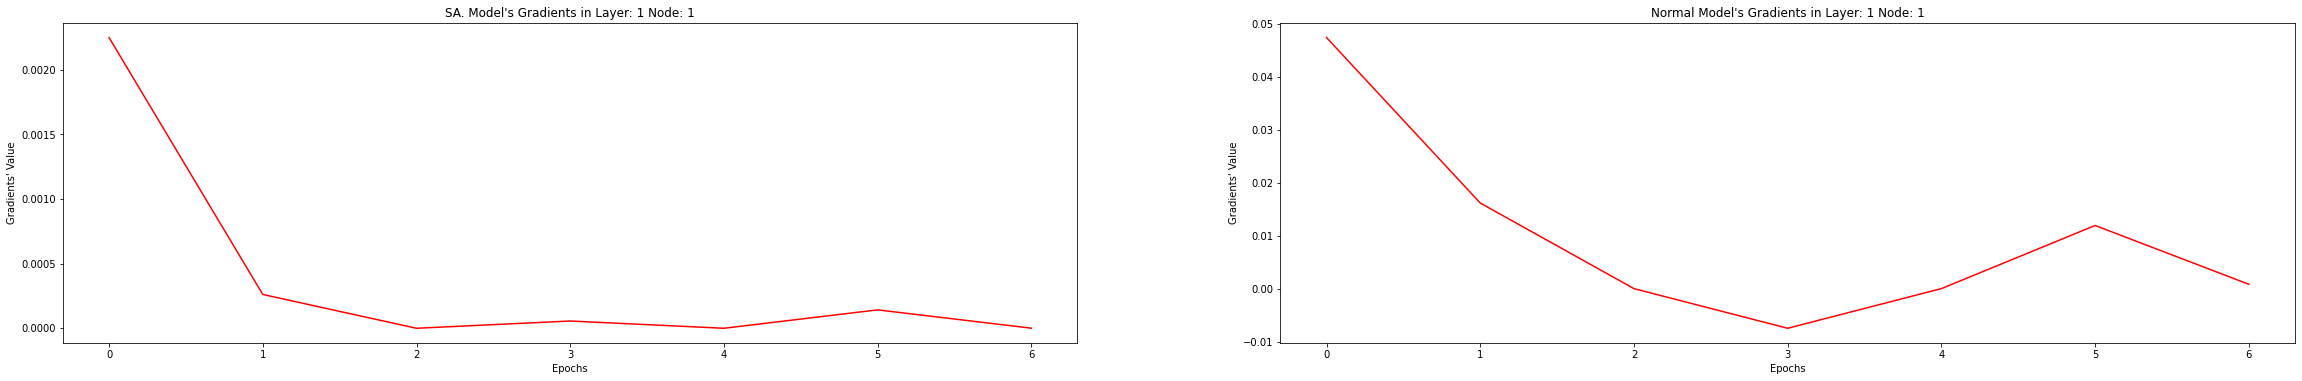

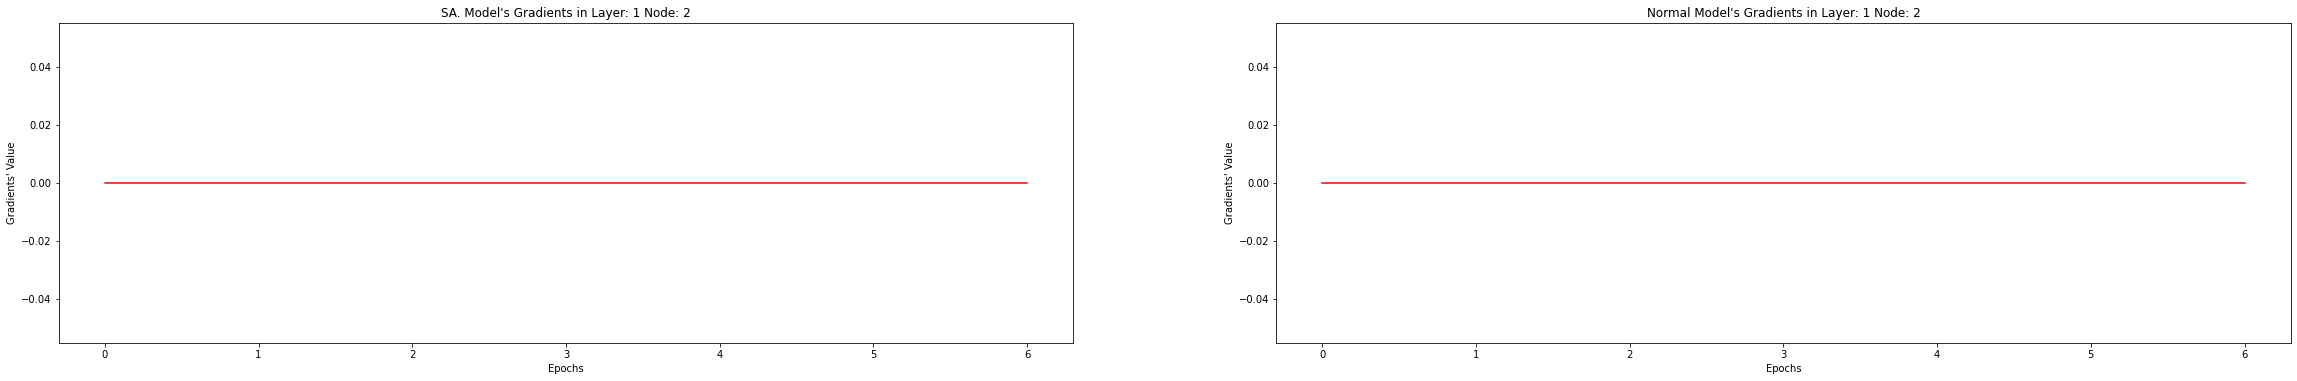

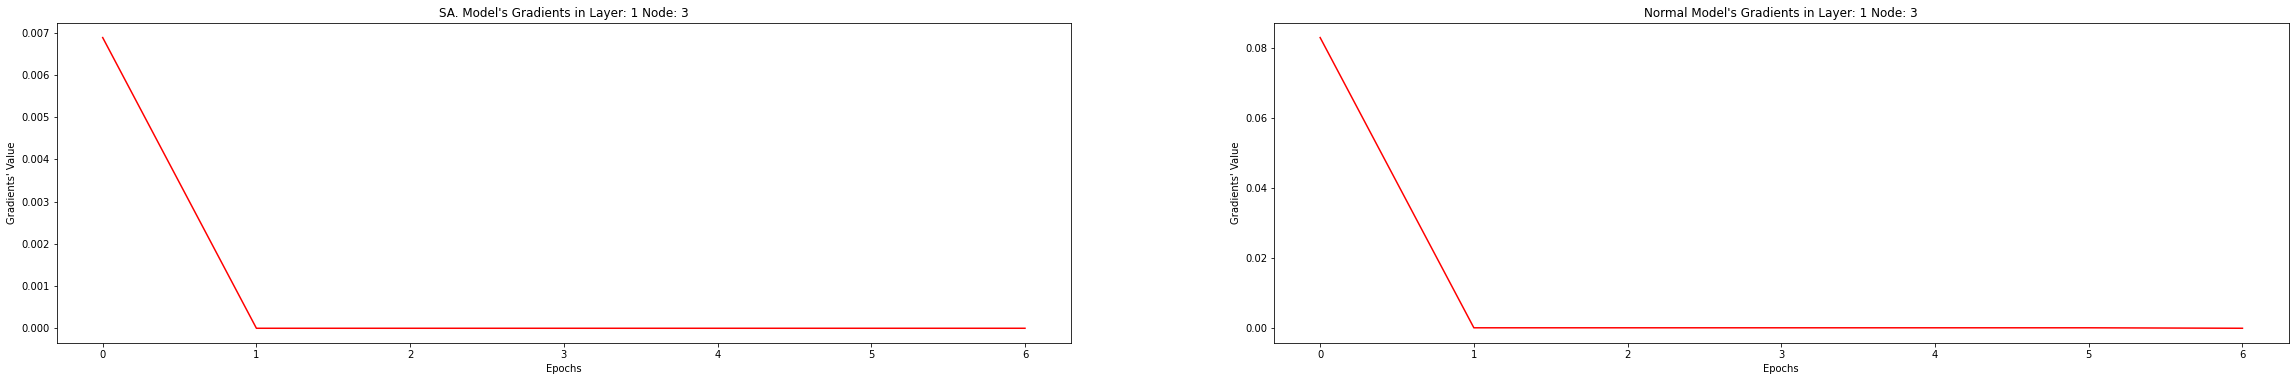

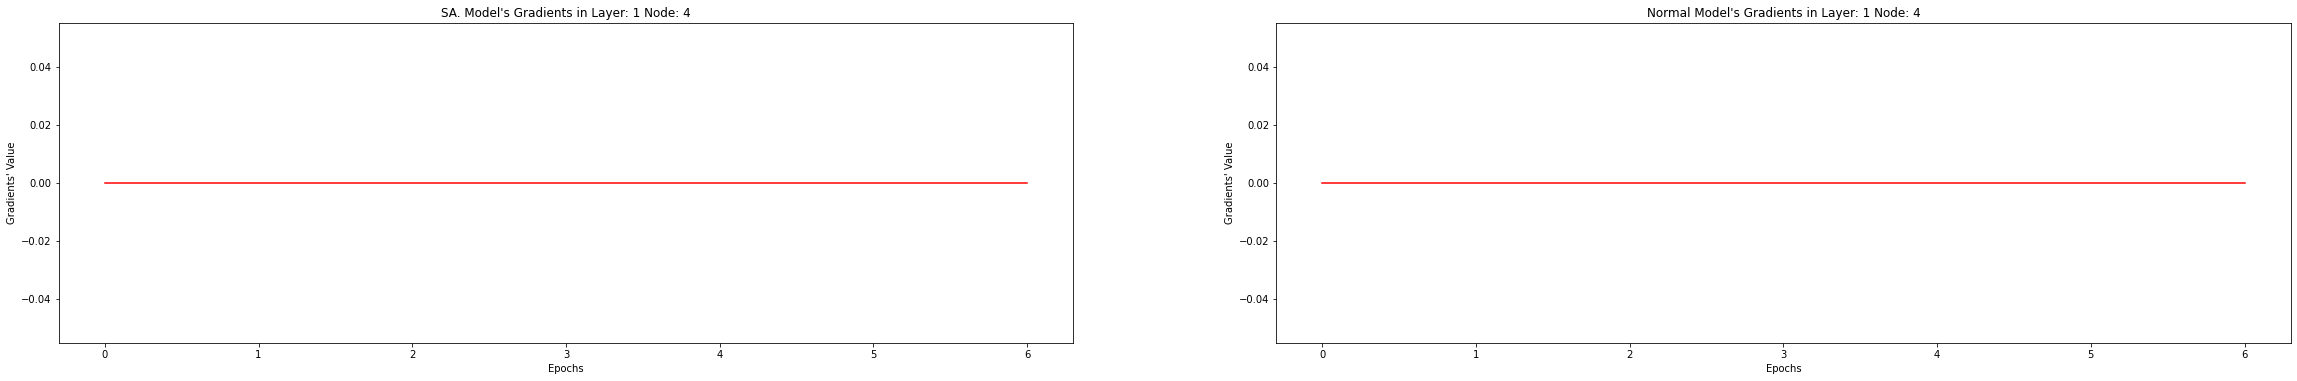

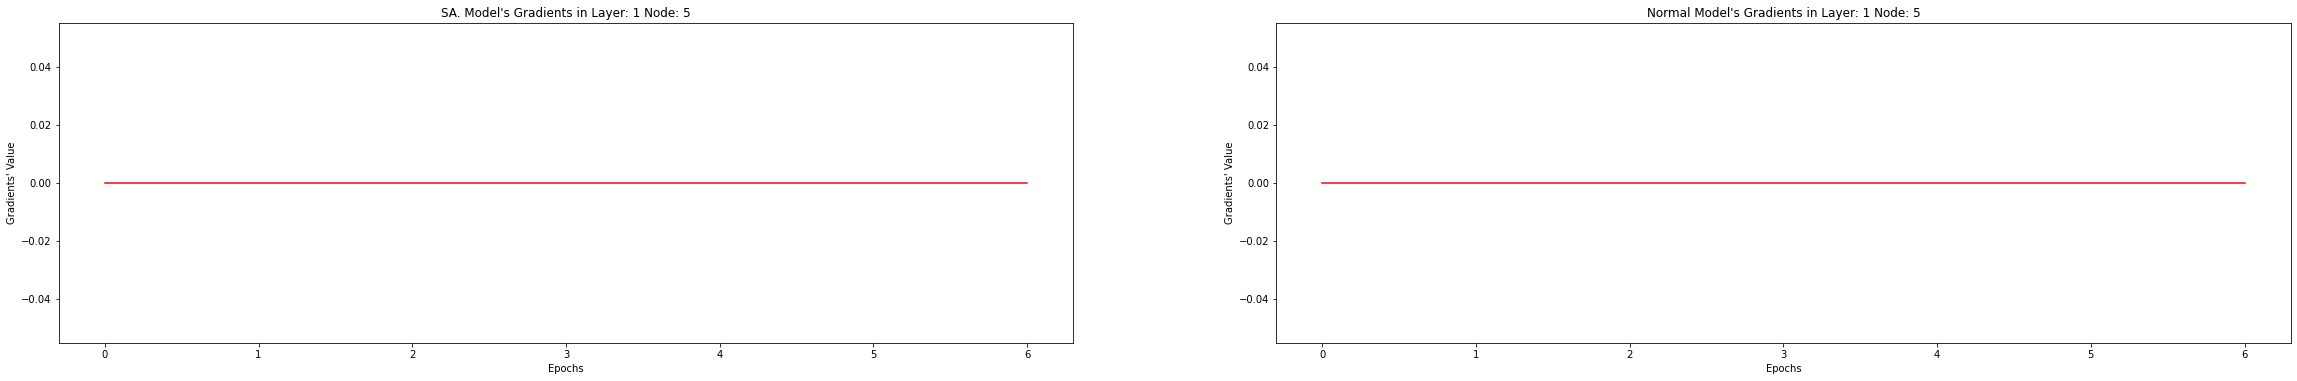

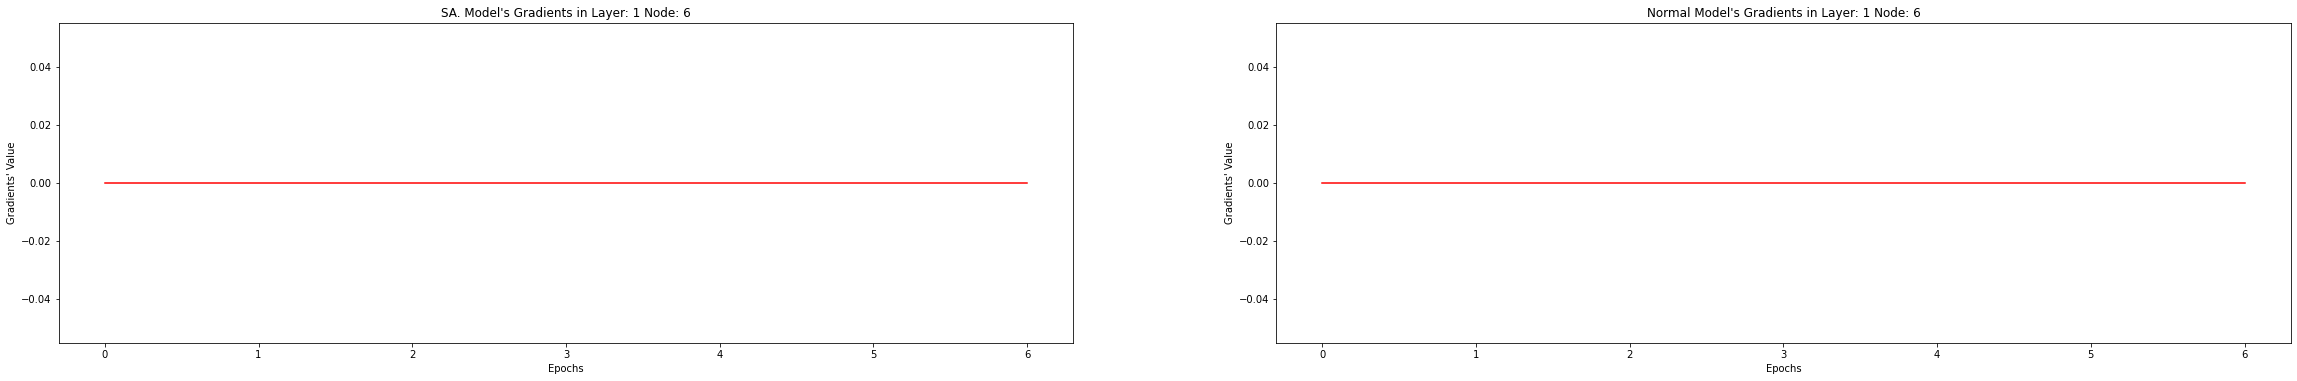

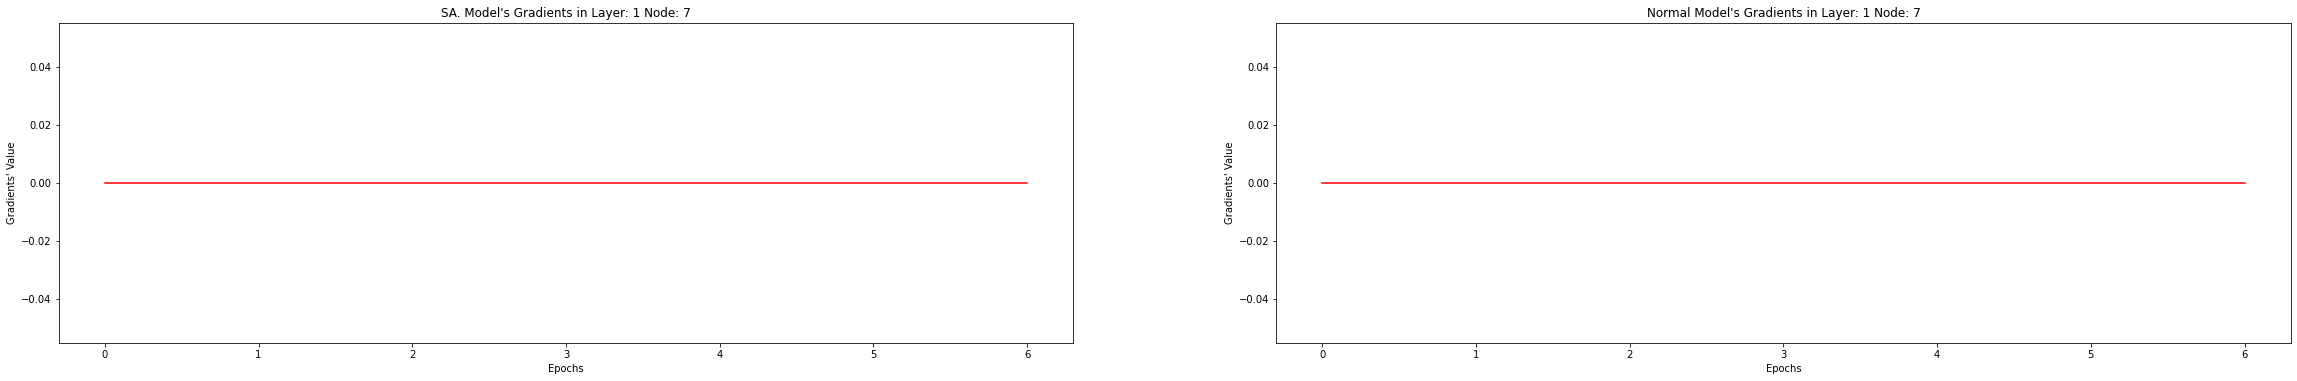

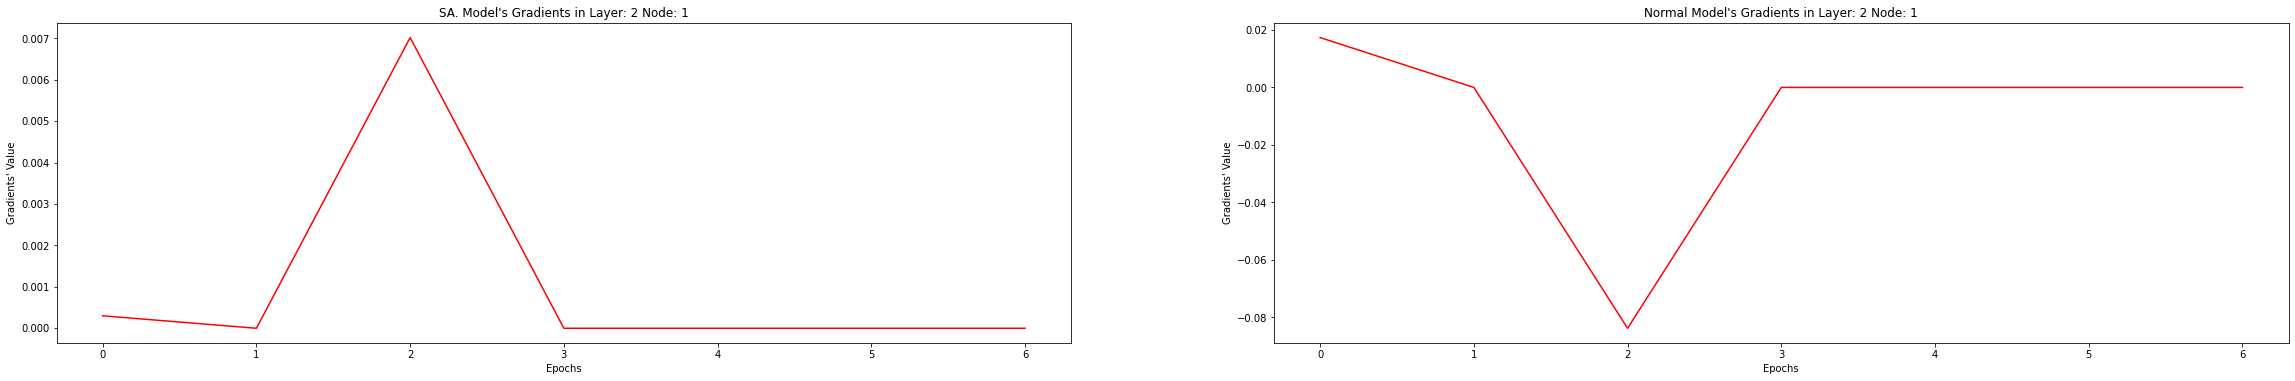

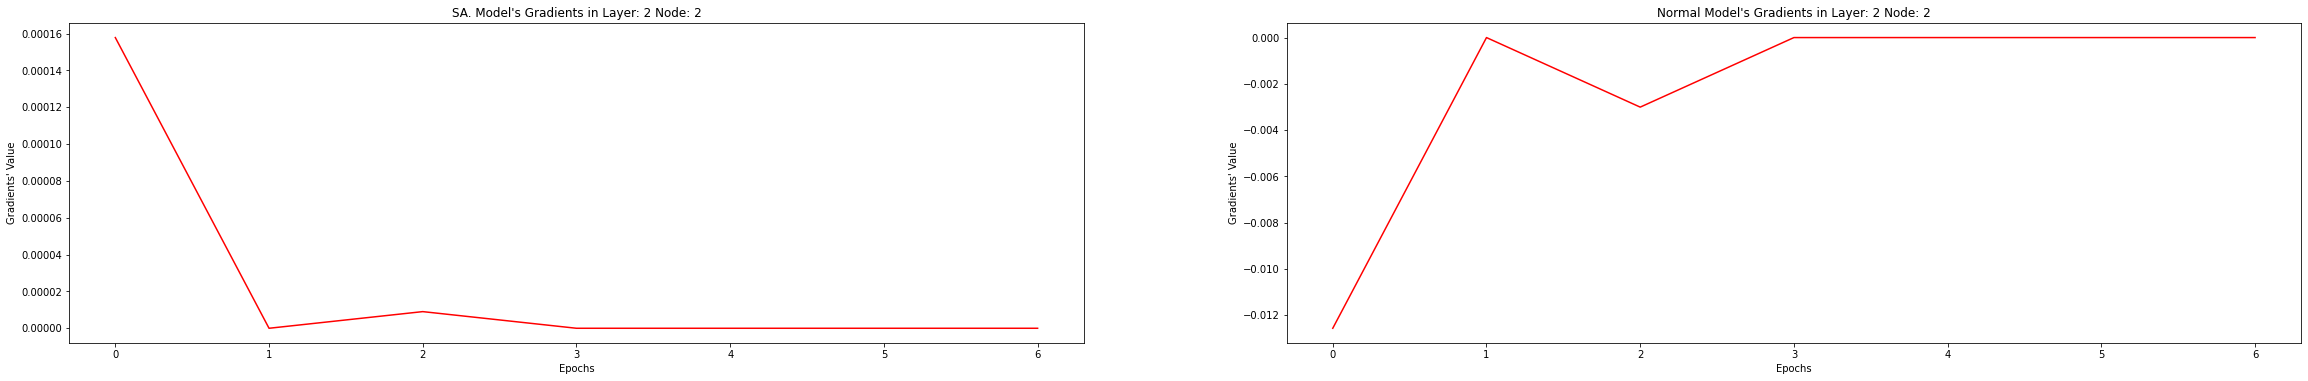

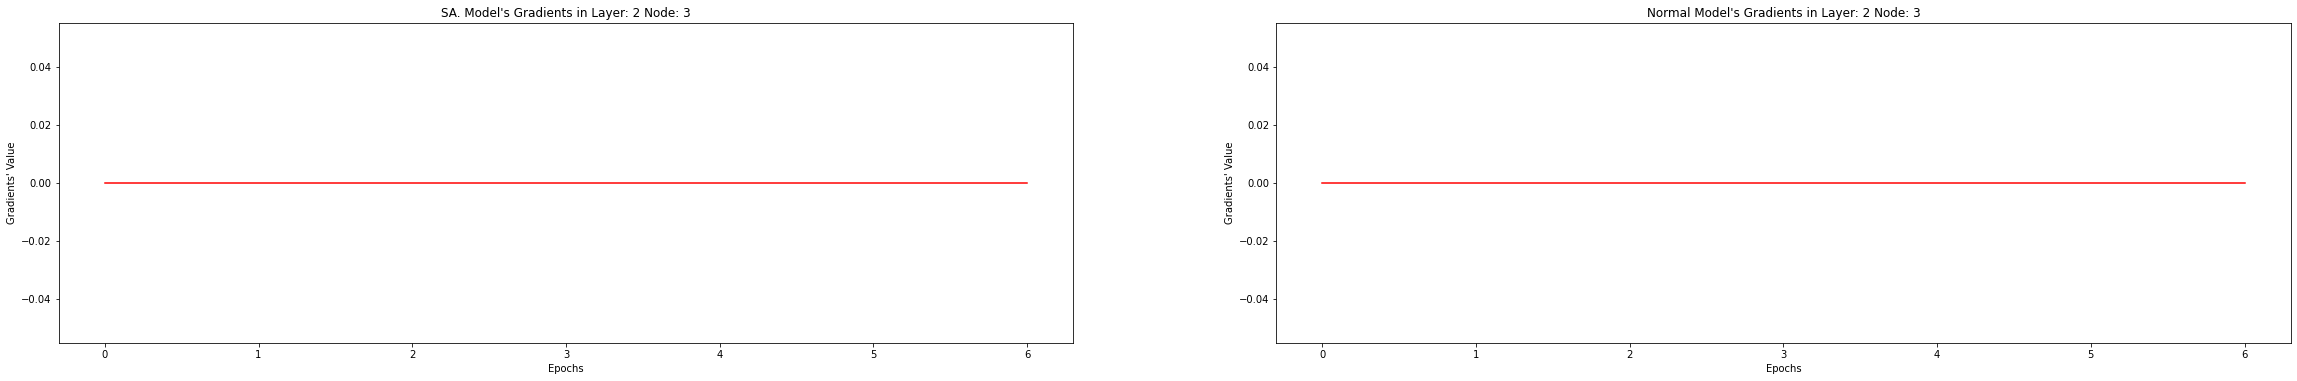

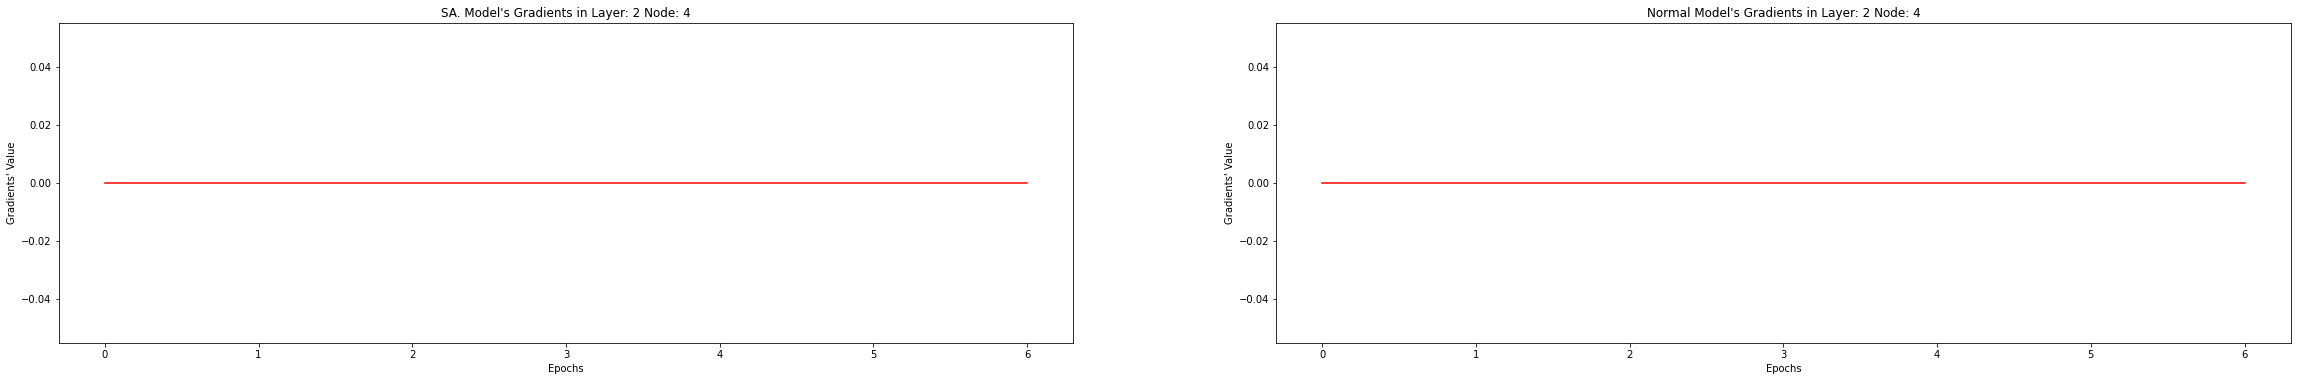

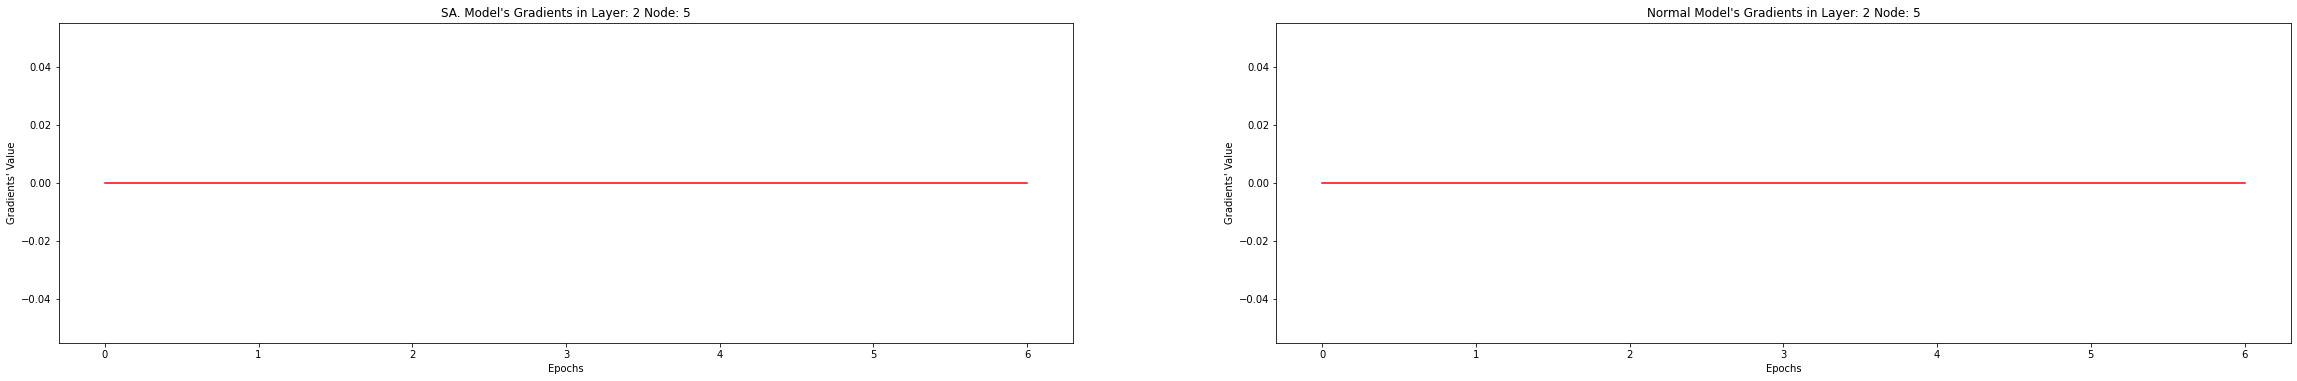

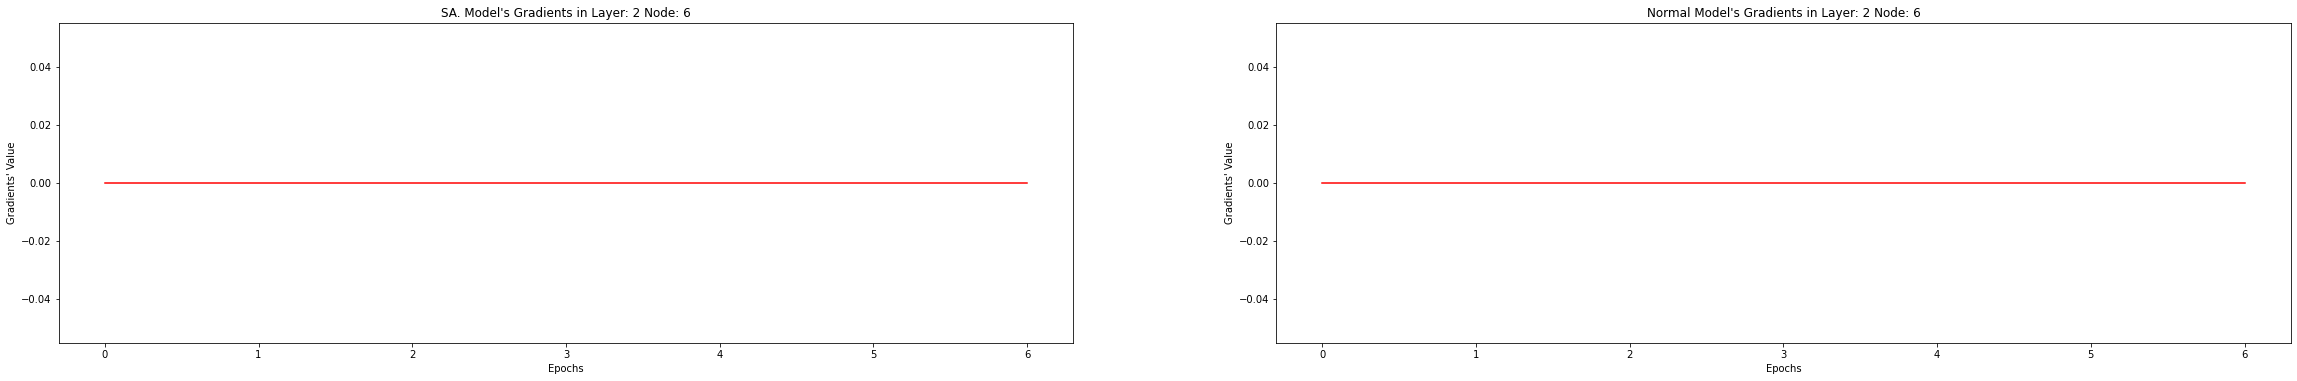

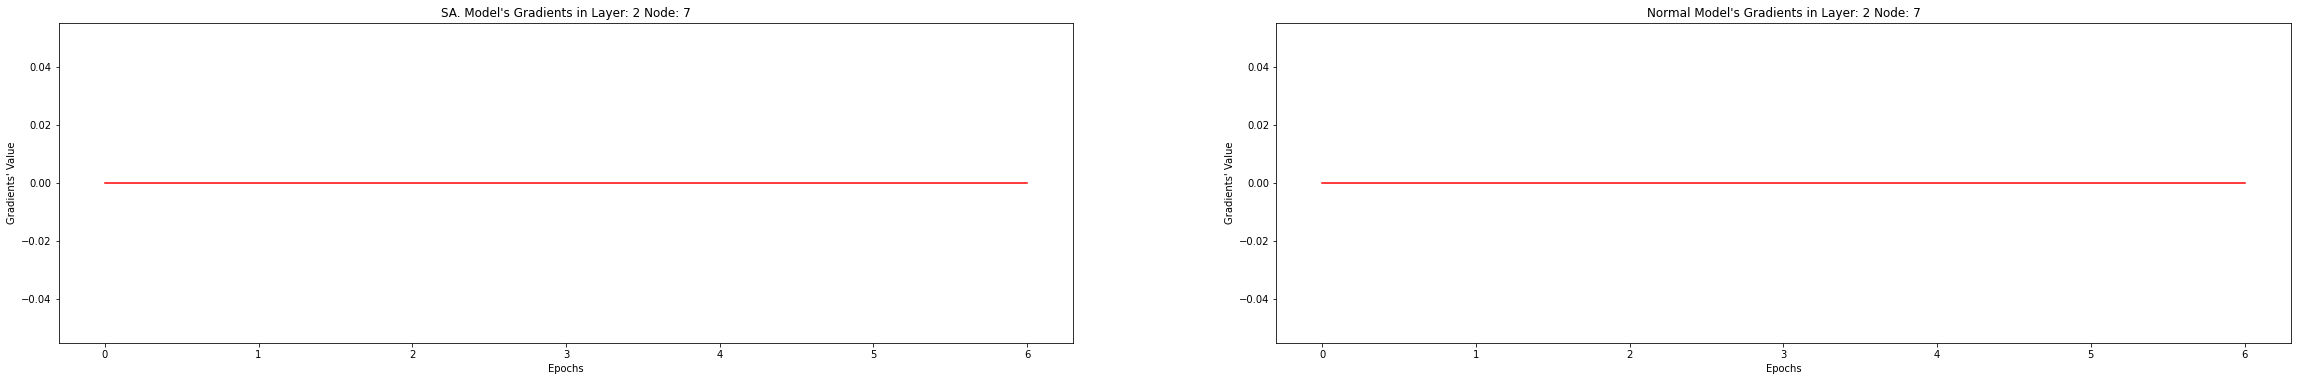

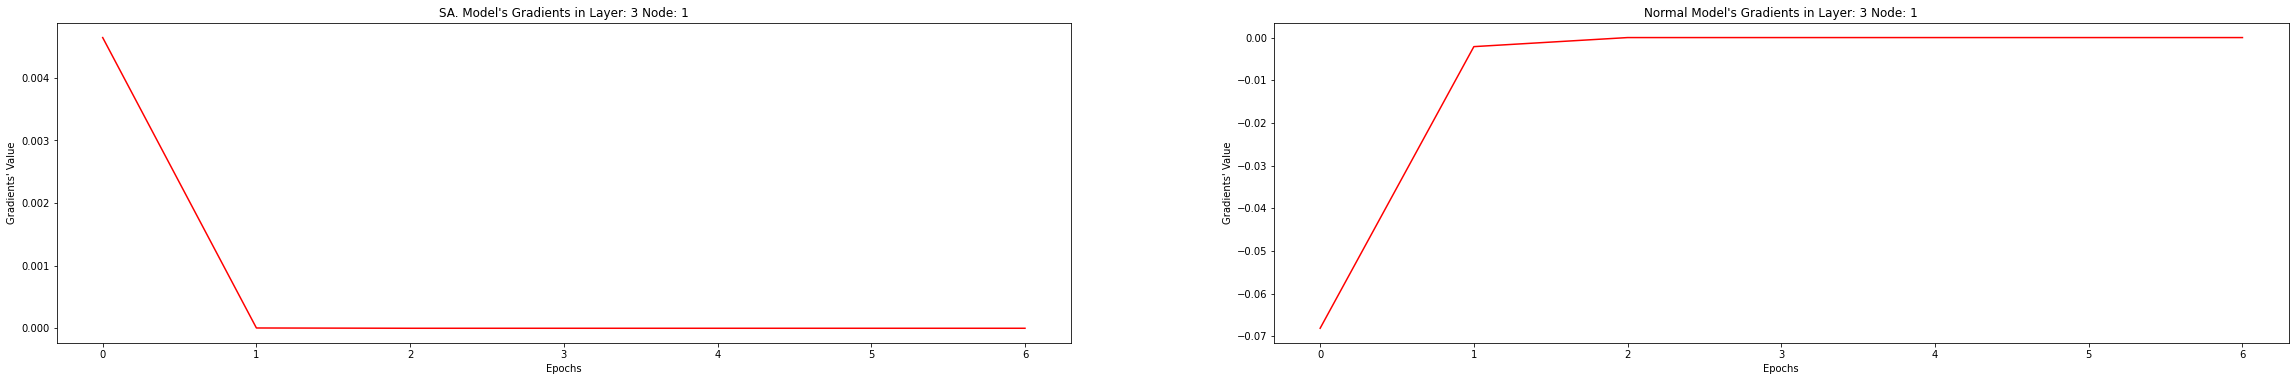

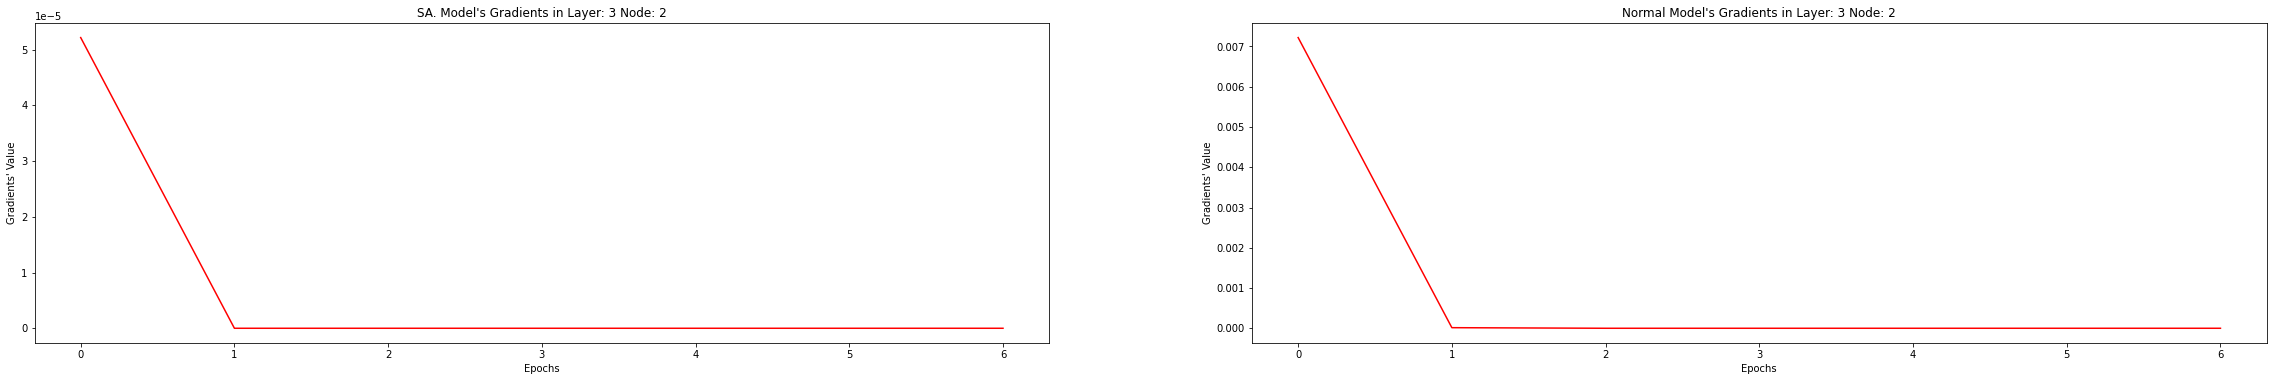

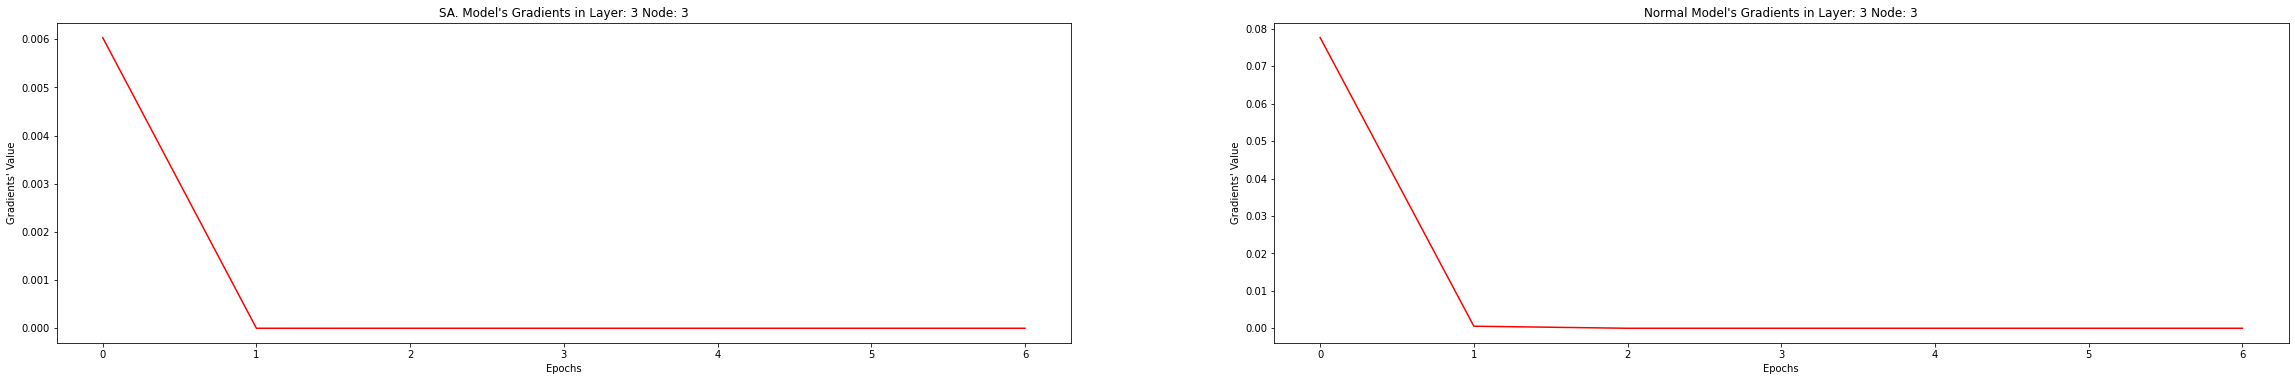

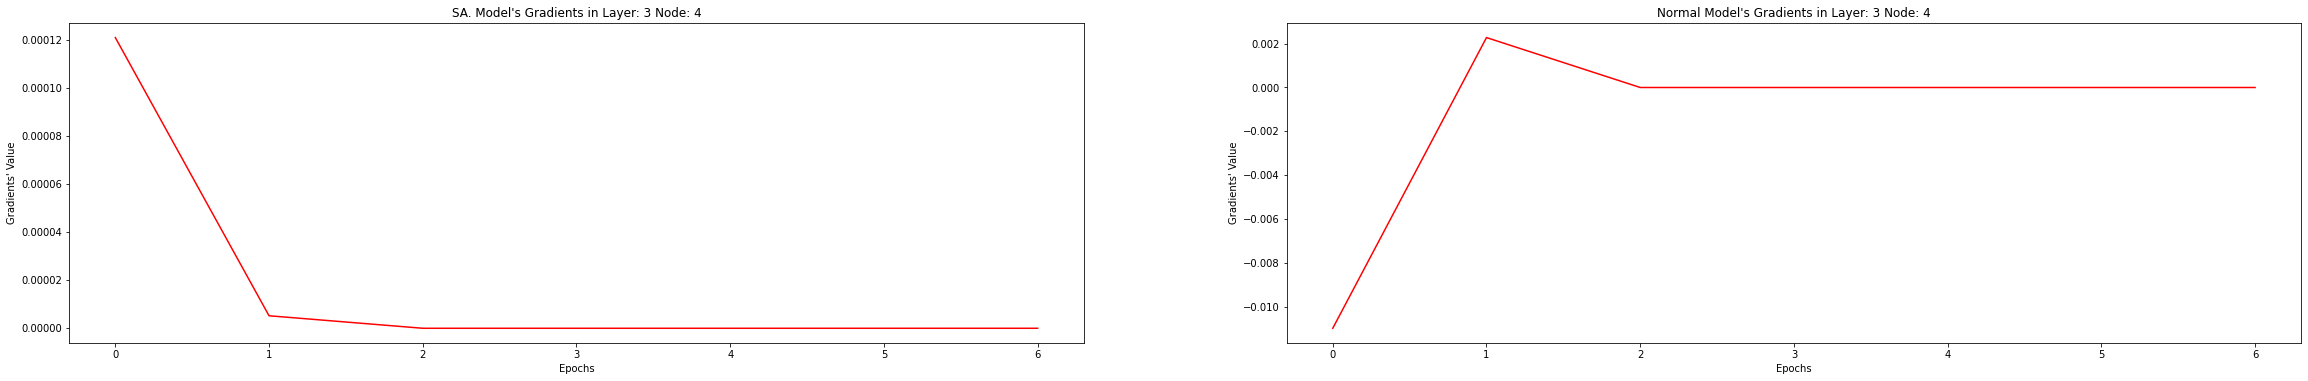

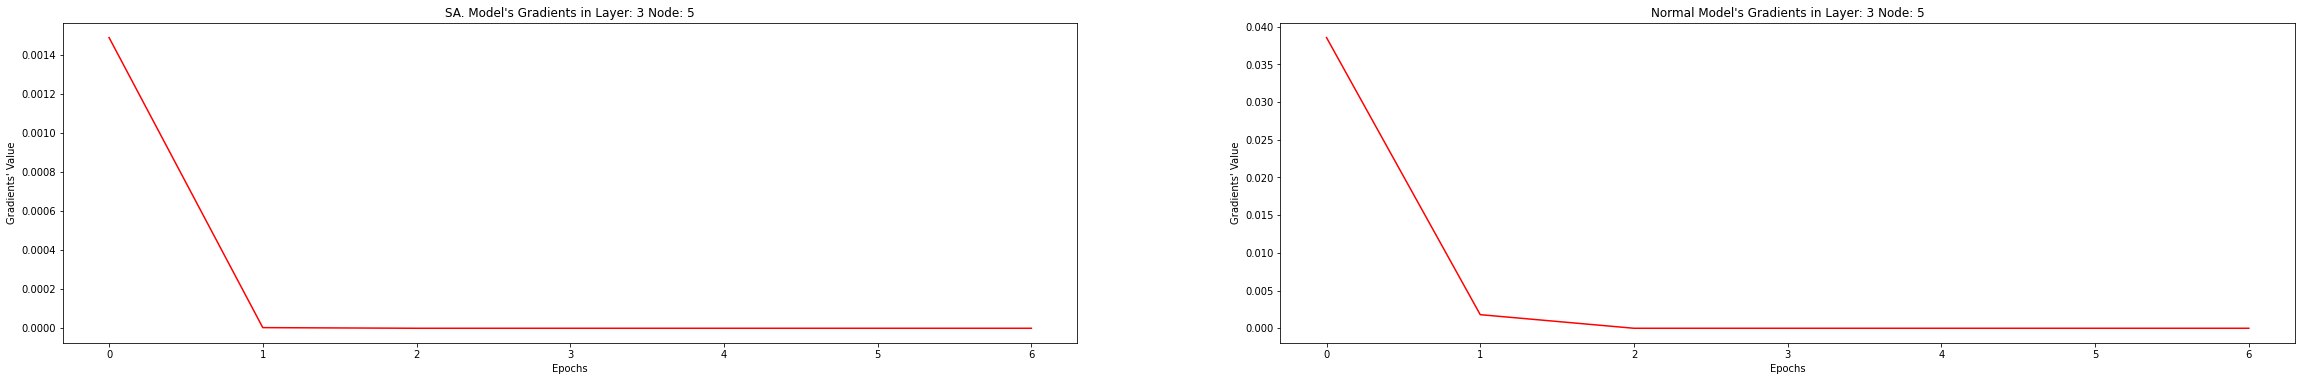

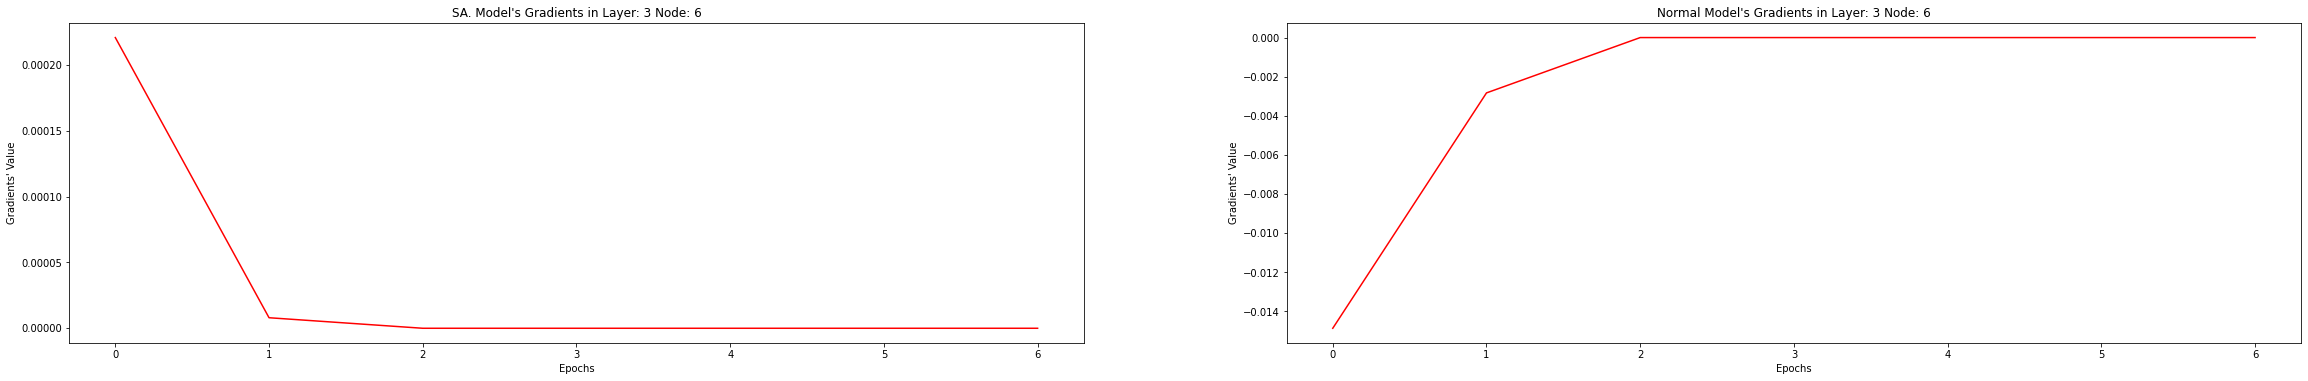

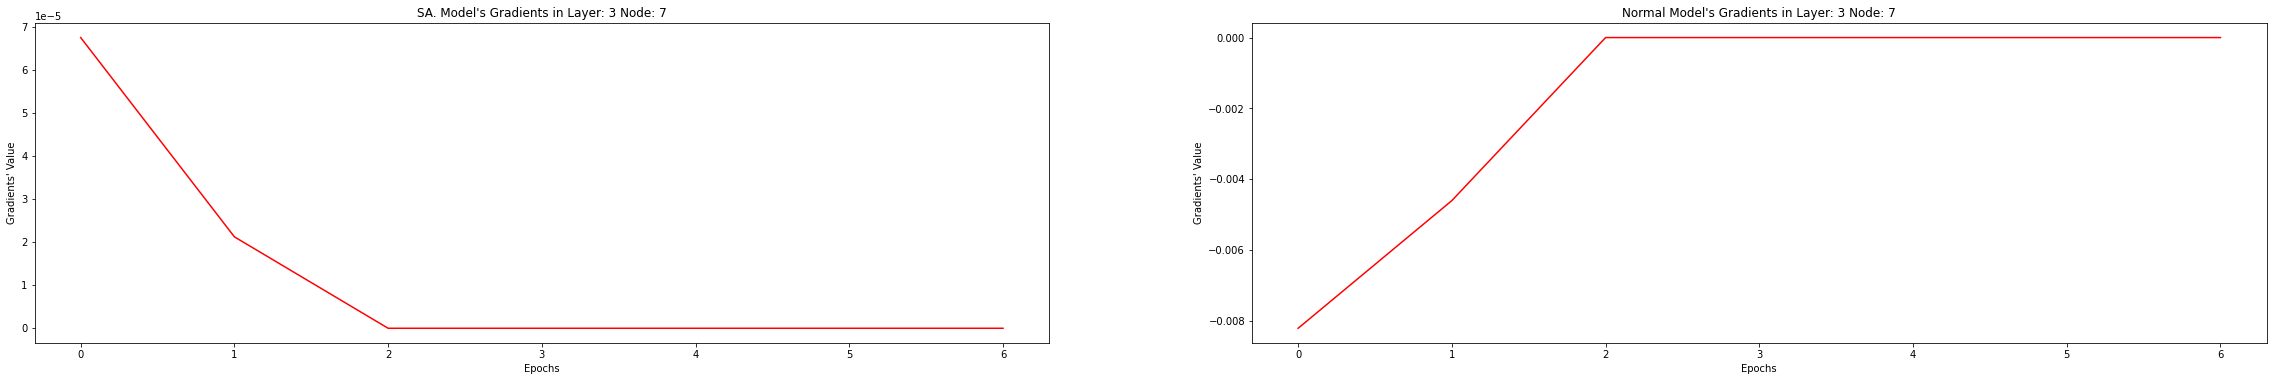

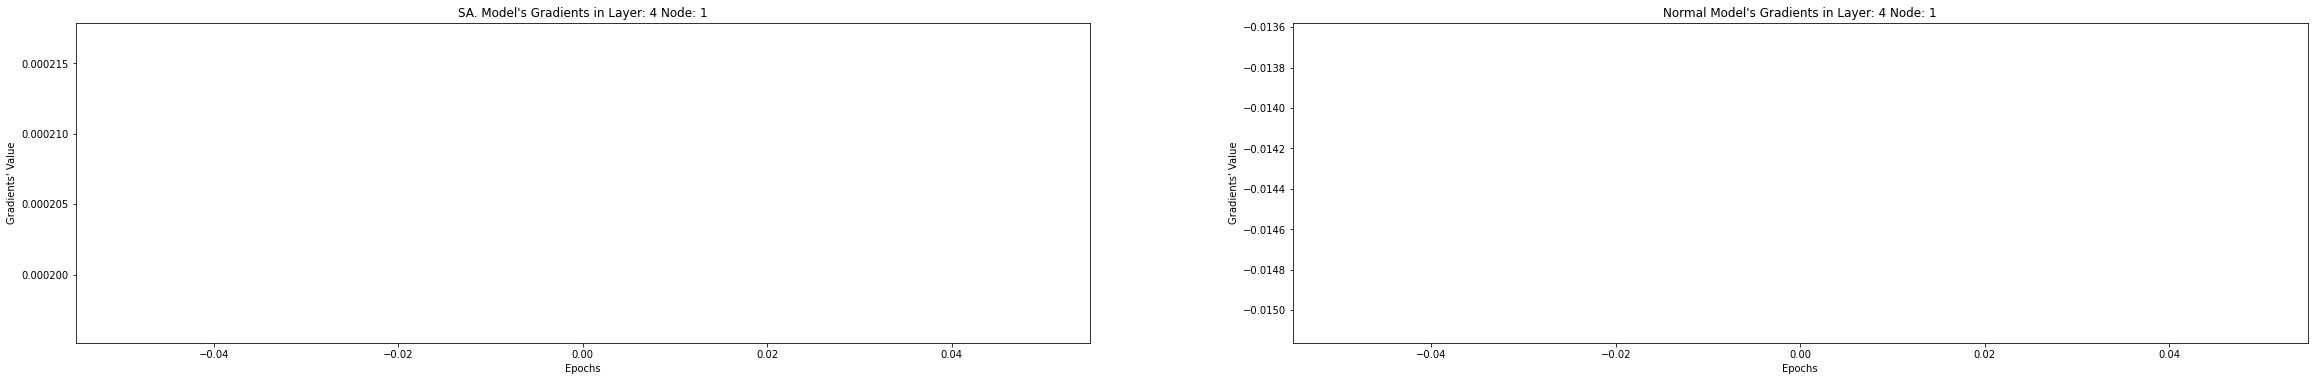

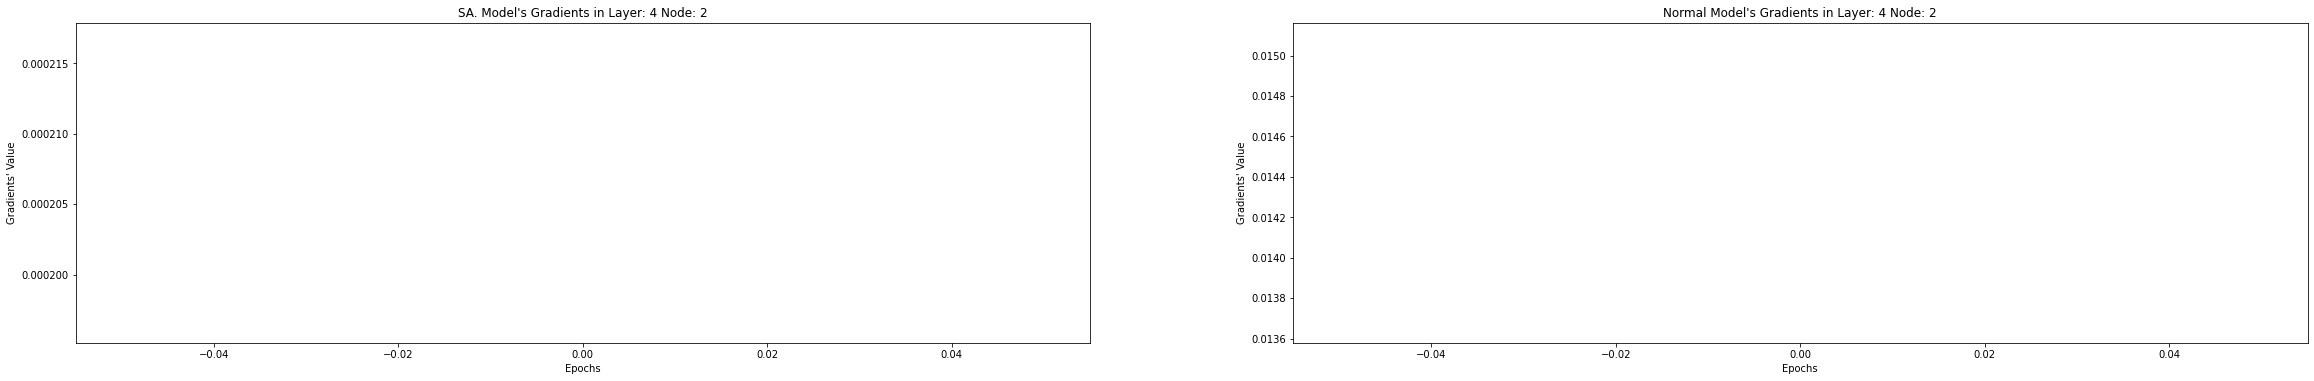

In [ ]:
SA_model_gradients_of_hidden_nodes(holder_of_new_gradients, holder_of_old_gradients, EPOCHS)

In [ ]:
def accumulate_gradients(model_for_you):
  before_SA = []
  after_SA = []

  for name, param in model_for_you.named_parameters():

    if name == "conv1.bias":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())
    if name == "conv1.lin.weight":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())

    if name == "conv2.bias":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())
    if name == "conv2.lin.weight":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())

    if name == "conv3.bias":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())
    if name == "conv3.lin.weight":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())

    if name == "lin.weight":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())
    if name == "lin.bias":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())


  return before_SA, after_SA

In [ ]:
holder_of_old_gradients, holder_of_new_gradients = accumulate_gradients(SA_model_GCN)

In [ ]:
print(np.shape(holder_of_new_gradients[1]))
print(np.shape(square_grads_wrt_graph_label))
print(np.shape(test_dataset[0].x))

NameError: ignored

In [ ]:
for name, param in SA_model_GCN.named_parameters():
  print(name)

conv1.bias
conv1.lin.weight
conv2.bias
conv2.lin.weight
conv3.bias
conv3.lin.weight
lin.weight
lin.bias


In [ ]:
print(len(holder_of_old_gradients))
print(len(holder_of_old_gradients[6]))
print(holder_of_old_gradients[6])
print(holder_of_old_gradients[7])

8
2
[[0.0010444223880767822, 0.024098075926303864, 0.02370644547045231, -0.022749999538064003, 0.013384955935180187, -0.005045591853559017, -0.03951691836118698], [-0.0010444223880767822, -0.024098075926303864, -0.02370644360780716, 0.0227500032633543, -0.013384956866502762, 0.005045592784881592, 0.03951692581176758]]
[-0.014370352029800415, 0.014370355755090714]


In [ ]:
def accumulate_weights(model_for_you):
  before_SA = []
  after_SA = []
  StateDict = model_for_you.state_dict()    # STATE DICT is for Weights and Biases

  Conv1_biases = StateDict.get('conv1.bias')
  Conv1_Weights = StateDict.get('conv1.lin.weight')

  Conv2_biases = StateDict.get('conv2.bias')
  Conv2_Weights = StateDict.get('conv2.lin.weight')

  Conv3_biases = StateDict.get('conv3.bias')
  Conv3_Weights = StateDict.get('conv3.lin.weight')

  Dense_biases = StateDict.get('lin.bias')
  Dense_Weights = StateDict.get('lin.weight')

  before_SA.append(Conv1_biases.detach().tolist())
  Conv1_biases = torch.square(Conv1_biases)
  after_SA.append(Conv1_biases.detach().tolist())


  before_SA.append(Conv1_Weights.detach().tolist())
  Conv1_Weights = torch.square(Conv1_Weights)
  after_SA.append(Conv1_Weights.detach().tolist())


  before_SA.append(Conv2_biases.detach().tolist())
  Conv2_biases = torch.square(Conv2_biases)
  after_SA.append(Conv2_biases.detach().tolist())

  before_SA.append(Conv2_Weights.detach().tolist())
  Conv2_Weights = torch.square(Conv2_Weights)
  after_SA.append(Conv2_Weights.detach().tolist())


  before_SA.append(Conv3_biases.detach().tolist())
  Conv3_biases = torch.square(Conv3_biases)
  after_SA.append(Conv3_biases.detach().tolist())

  before_SA.append(Conv3_Weights.detach().tolist())
  Conv3_Weights = torch.square(Conv3_Weights)
  after_SA.append(Conv3_Weights.detach().tolist())


  before_SA.append(Dense_biases.detach().tolist())
  Dense_biases = torch.square(Dense_biases)
  after_SA.append(Dense_biases.detach().tolist())

  before_SA.append(Dense_Weights.detach().tolist())
  Dense_Weights = torch.square(Dense_Weights)
  after_SA.append(Dense_Weights.detach().tolist())


  return before_SA, after_SA

In [ ]:
holder_of_old_weights, holder_of_new_weights = accumulate_weights(SA_model_GCN)

In [ ]:
print(len(holder_of_old_weights[7]))
print(holder_of_old_weights[7])

2
[[-0.009932374581694603, 0.27527955174446106, -0.5595436096191406, 0.5777831673622131, 0.33545270562171936, -0.5036705136299133, 0.03947649896144867], [0.5142185091972351, -0.28258493542671204, 0.5496687293052673, -0.45988816022872925, -0.3799608051776886, 0.19227394461631775, 0.6062339544296265]]


In [ ]:
print(SA_model_GCN.conv1)
sd = SA_model_GCN.state_dict()
print(sd.keys())
whole_weights = sd.items()
#print(whole_weights)

GCNConv(7, 7)
odict_keys(['conv1.bias', 'conv1.lin.weight', 'conv2.bias', 'conv2.lin.weight', 'lin.weight', 'lin.bias'])


In [ ]:
'''def train_step():
  before_square = []
  after_square = []
  SA_loss_batch = []


  SA_model_GCN.train()
  SA_optimizer.zero_grad()
  for batched_data in train_loader:
    SA_out = SA_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
    SA_loss = loss_calculations(SA_out, batched_data.y)
    SA_loss_batch.append(SA_loss)
    SA_loss.backward()
    SA_optimizer.step()

    batched_before_square = []
    batched_after_square = []

    for name, param in SA_model_GCN.named_parameters():

      if name == "conv1.bias":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())
      if name == "conv1.lin.weight":
        #print(param.grad.detach().clone())
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())

      if name == "conv2.bias":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())
      if name == "conv2.lin.weight":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())

      if name == "conv3.bias":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())
      if name == "conv3.lin.weight":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())

      if name == "lin.bias":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())
      if name == "lin.weight":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())

    before_square.append(batched_before_square)
    after_square.append(batched_after_square)
  #print(len(before_square[-1]))

  non_SA_backpropagation_SAME_MODEL(before_square)
  SA_backpropagation_SAME_MODEL(after_square)

  SA_optimizer.step()

  #############################################################

  non_SA_model_GCN.train()
  for data in train_loader:
    non_SA_out = non_SA_model_GCN(data.x, data.edge_index, data.batch)
    non_SA_loss = loss_calculations(non_SA_out, data.y)
    non_SA_loss_batch.append(non_SA_loss)
    non_SA_loss.backward()
    non_SA_optimizer.step()
    non_SA_optimizer.zero_grad()



  return torch.mean(torch.tensor(SA_loss_batch)), torch.mean(torch.tensor(non_SA_loss_batch))
'''

'def train_step():\n  before_square = []\n  after_square = []\n  SA_loss_batch = []\n\n\n  SA_model_GCN.train()\n  SA_optimizer.zero_grad()\n  for batched_data in train_loader:\n    SA_out = SA_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)\n    SA_loss = loss_calculations(SA_out, batched_data.y)\n    SA_loss_batch.append(SA_loss)\n    SA_loss.backward()\n    SA_optimizer.step()\n\n    batched_before_square = []\n    batched_after_square = []\n\n    for name, param in SA_model_GCN.named_parameters():\n\n      if name == "conv1.bias":\n        batched_before_square.append(param.grad.detach().clone())\n        param.grad = torch.square(param.grad)\n        batched_after_square.append(param.grad.detach().clone())\n      if name == "conv1.lin.weight":\n        #print(param.grad.detach().clone())\n        batched_before_square.append(param.grad.detach().clone())\n        param.grad = torch.square(param.grad)\n        batched_after_square.append(param.grad.detach().cl

In [ ]:
print(holder_of_new_gradients[1])
print(test_dataset[0].x)

[[0.0022492827847599983, 0.0002615263219922781, 0.0, 5.6101260270224884e-05, 0.0, 0.00014226508210413158, 6.721147087773716e-07], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.006882885936647654, 0.0, 0.0, 0.0, 0.0, 0.0, 1.83770971773356e-08], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
      

## **Stability**

In [ ]:
top_k_features = 0.25
top_k = np.ceil(top_k_features * dataset[0].size()[1])
print(top_k, dataset[0].x.size()[1])
cont_noise = torch.ones(dataset[0].x.size()[1]).normal_(0, 0.1)
print(cont_noise)

5.0 7
tensor([ 0.0263,  0.0245,  0.0914, -0.0323, -0.0329, -0.1178,  0.1723])


In [ ]:
from networkx.algorithms.swap import double_edge_swap as swap
from networkx.linalg.graphmatrix import adjacency_matrix as adj_mat
def rewire_edges(x, edge_index, degree):

    data = Data(x=x, edge_index=edge_index)
    G = convert.to_networkx(data, to_undirected=True)
    rewired_G = swap(G, nswap=degree, max_tries=degree * 25, seed=912)
    rewired_adj_mat = adj_mat(rewired_G)
    rewired_edge_indexes = convert.from_scipy_sparse_matrix(rewired_adj_mat)[0]

    return rewired_edge_indexes

In [ ]:
stability = []
lg_norm_sm_faithfulness = []
for idx in tqdm.tqdm(np.random.randint(0, idx_test.shape[0], idx_test.shape[0])):
    node_idx = idx_test[idx].item()
    num_hops = 1
    subset, sub_edge_index, mapping, hard_edge_mask = k_hop_subgraph(
        node_idx, num_hops, edge_index, relabel_nodes=True,
        num_nodes=features.size(0))
    sub_x = features[subset]

    sub_num_edges = sub_edge_index.size(1)
    sub_num_nodes, num_features = sub_x.size()

    # Metrics
    exp_feat_metrics = FeatMetrics(model, labels.to(device), sub_edge_index, mapping, device)
    exp_edge_metrics = EdgeMetrics(model, labels.to(device), sub_edge_index, mapping, args.algo, device)

In [ ]:
def calculate_feat_exp_metrics(node_idx, subset, sub_edge_index, mapping, sub_x, metrics, explainer, model, device,
                               degree, algo):

    # Single node
    top_k_features = 0.25
    top_k = np.ceil(top_k_features * sub_x.shape[1])

    sub_x.requires_grad = True
    perturbed_nodes = [sub_x.clone()]
    node_explanation = explainer.explain(sub_x)

    ind = torch.where(subset == node_idx)[0].item()

    # Stability
    with torch.no_grad():
        cont_noise = torch.ones(sub_x.shape[1]).normal_(0, args.var)
        catg_temp = torch.zeros_like(cont_noise)
        pert_sub_x = sub_x.clone()
        pert_sub_x[ind, :] += cont_noise
    pert_sub_x.requires_grad = True
    try:
        rewire_edge_index = rewire_edges(x=sub_x, edge_index=sub_edge_index, degree=degree)[:, :sub_edge_index.shape[1]]
    except:
        return None

    # get predictions for original and perturbed node
    out_x = model(sub_x.to(device), sub_edge_index.to(device))
    preds_x = torch.argmax(out_x, dim=-1)

    out_pert_x = model(pert_sub_x.to(device), rewire_edge_index.to(device))
    preds_pert_x = torch.argmax(out_pert_x, dim=-1)

    if preds_x[mapping].item() == preds_pert_x[mapping].item():
        _ = torch.randn(sub_edge_index[0, :].shape)
        _ = torch.randn(sub_x[0, :].shape)
        if algo == 'graphlime':
            pert_node_explanation, _, _ = explainer.explain(pert_sub_x)
        else:
            pert_node_explanation = explainer.explain(pert_sub_x)
        if algo in ['grad', 'graphlime', 'ig']:
            _ = torch.randn(sub_x[0, :].shape)
        _ = torch.randn(sub_edge_index[0, :].shape)
        model = model.to(device)
        stab_score = metrics.dist_explanation(node_explanation, pert_node_explanation, top_k, ind)
    else:
        return None


    return stab_score, lg_norm_softmax_score


In [ ]:
cont_noise = torch.ones(7).normal_(0, 0.1)
print(cont_noise)

tensor([-0.0351,  0.0300,  0.0008, -0.1803, -0.0438,  0.1662, -0.1841])


In [ ]:
import copy

In [ ]:
def perturb_node_features_of_dataset(dataset, mean, std):
    """
        Pertub Node Features for Entire Dataset
    """
    dataset_perturbed = copy.deepcopy(dataset)
    for graph in dataset_perturbed:
        continuous_noise = torch.ones(dataset[0].x.size()[1]).normal_(mean, std)
        graph.x += continuous_noise
    return dataset_perturbed

In [ ]:
perturbed_dataset = perturb_node_features_of_dataset(dataset, mean=0.1, std=0.1)

In [ ]:
print(perturbed_dataset[0].x)

tensor([[ 1.1772e+00, -1.2188e-03,  4.2796e-02,  4.9077e-02,  1.5859e-01,
         -7.6098e-04,  1.8116e-01],
        [ 1.1772e+00, -1.2188e-03,  4.2796e-02,  4.9077e-02,  1.5859e-01,
         -7.6098e-04,  1.8116e-01],
        [ 1.1772e+00, -1.2188e-03,  4.2796e-02,  4.9077e-02,  1.5859e-01,
         -7.6098e-04,  1.8116e-01],
        [ 1.1772e+00, -1.2188e-03,  4.2796e-02,  4.9077e-02,  1.5859e-01,
         -7.6098e-04,  1.8116e-01],
        [ 1.1772e+00, -1.2188e-03,  4.2796e-02,  4.9077e-02,  1.5859e-01,
         -7.6098e-04,  1.8116e-01],
        [ 1.1772e+00, -1.2188e-03,  4.2796e-02,  4.9077e-02,  1.5859e-01,
         -7.6098e-04,  1.8116e-01],
        [ 1.1772e+00, -1.2188e-03,  4.2796e-02,  4.9077e-02,  1.5859e-01,
         -7.6098e-04,  1.8116e-01],
        [ 1.1772e+00, -1.2188e-03,  4.2796e-02,  4.9077e-02,  1.5859e-01,
         -7.6098e-04,  1.8116e-01],
        [ 1.1772e+00, -1.2188e-03,  4.2796e-02,  4.9077e-02,  1.5859e-01,
         -7.6098e-04,  1.8116e-01],
        [ 

## **Stability Implementation**

In [379]:
class evalaution_of_xmethods_stability(object):
    def __init__(self, a_trained_model, test_data):
        """
            Perturb Node Features for Entire Dataset
            Explain perturbed dataset
            Compute their distance
        """
        super(evalaution_of_xmethods_stability, self).__init__()

        self.a_trained_model = a_trained_model
        self.test_data = test_data


    def normalize_saliency_node_features_based(self, sal_maps):
        Graphs_new_gradients = []
        for graph_grads in sal_maps:
            new_gradients = []
            for node_grads in graph_grads:
                node_gradients = []
                for dim in node_grads:
                    node_gradients.append((dim-min(node_grads))/(max(node_grads)-min(node_grads)) if (max(node_grads)-min(node_grads)) != 0 else 0)
                new_gradients.append(node_gradients)
            Graphs_new_gradients.append(new_gradients)

        return Graphs_new_gradients

    def normalize_saliency_node_based(self, sal_maps):
        Graphs_new_gradients = []
        for graph_grads in sal_maps:
            new_gradients = []
            for node_grads in graph_grads:
                val = (node_grads-min(graph_grads))/(max(graph_grads)-min(graph_grads)) if (max(graph_grads)-min(graph_grads)) != 0 else 0
                new_gradients.append(val)
            Graphs_new_gradients.append(new_gradients)

        return Graphs_new_gradients

    def normalize_stability_distance(self, distance_list):
        normalized_distance_list = []
        for exp_diff in distance_list:
            val = (exp_diff-min(distance_list))/(max(distance_list)-min(distance_list)) if (max(distance_list)-min(distance_list)) != 0 else 0
            normalized_distance_list.append(val)
        return normalized_distance_list

    def perturb_node_features_of_dataset(self, dataset, mean, std):
        dataset_perturbed = copy.deepcopy(dataset)
        for graph in dataset_perturbed:
            continuous_noise = torch.ones(dataset[0].x.size()[1]).normal_(mean, std)
            graph.x += continuous_noise
        return dataset_perturbed

    def dist_explanation(self, normal_saliency, perturbed_saliency, top_k_features):
        distance_list = []
        for normal_graph, perturbed_graph in zip(normal_saliency, perturbed_saliency):
            perturbed_graph = np.array(perturbed_graph)
            perturbed_graph = torch.from_numpy(perturbed_graph)
            normal_graph = np.array(normal_graph)
            normal_graph = torch.from_numpy(normal_graph)

            normal_graph_mask = torch.where(normal_graph >= normal_graph.topk(top_k_features)[0][-1].item(),
                                            torch.ones_like(normal_graph), torch.zeros_like(normal_graph))
            perturbed_graph_mask = torch.where(perturbed_graph >= perturbed_graph.topk(top_k_features)[0][-1].item(),
                                                torch.ones_like(perturbed_graph), torch.zeros_like(perturbed_graph))

            distance = F.pairwise_distance(normal_graph_mask.unsqueeze(dim=0), perturbed_graph_mask.unsqueeze(dim=0), p=1) / normal_graph_mask.size()[0]
            distance_list.append(distance.tolist()[0])
        return distance_list

    def one_graph_all_together(self, normal_saliency, perturbed_saliency):
        normal_saliency_list = []
        perturbed_saliency_list = []
        for normal_graph, perturbed_graph in zip(normal_saliency, perturbed_saliency):
            normal_saliency_list.append([node_feat for node in normal_graph for node_feat in node])
            perturbed_saliency_list.append([node_feat for node in perturbed_graph for node_feat in node])
        return perturbed_saliency_list, perturbed_saliency_list

    def distance_thresholding_node_features(self, distance_list, importance_threshold):
        stability_list = []
        for graph_score in distance_list:
            if importance_threshold == graph_score == 0:
                stability_list.append(1)
            if importance_threshold == graph_score == 1:
                stability_list.append(0)
            if importance_threshold < graph_score:
                stability_list.append(1 - graph_score)
            else:
                stability_list.append(0)
        return stability_list

    def my_stability(self, normal_saliency, perturbed_saliency, top_k_features, importance_threshold, style):
        if style == "Node Feature":
            try:
                normal_saliency = self.normalize_saliency_node_features_based(normal_saliency)
                perturbed_saliency = self.normalize_saliency_node_features_based(perturbed_saliency)

                normal_saliency_list, perturbed_saliency_list = self.one_graph_all_together(normal_saliency, perturbed_saliency)

                distance_list = self.dist_explanation(normal_saliency_list, perturbed_saliency_list, top_k_features)
                distance_list = self.normalize_stability_distance(distance_list)
                stability_list = self.distance_thresholding_node_features(distance_list, importance_threshold)
                #print("distance_list: ", distance_list)
                #print("stability_list: ", stability_list)

                return mean(stability_list)
            except:
                print("attributions are not in appropriate shape")
        elif style == "Node":
            try:
                normal_saliency = self.normalize_saliency_node_based(normal_saliency)
                perturbed_saliency = self.normalize_saliency_node_based(perturbed_saliency)

                distance_list = self.dist_explanation(normal_saliency, perturbed_saliency, top_k_features)
                distance_list = self.normalize_stability_distance(distance_list)
                stability_list = self.distance_thresholding_node_features(distance_list, importance_threshold)
                #print("distance_list: ", distance_list)
                #print("stability_list: ", stability_list)

                return mean(stability_list)
            except:
                print("attributions are not in appropriate shape")
        elif style =="Edge":
            try:
                normal_saliency = self.normalize_saliency_edge_based(normal_saliency)
                perturbed_saliency = self.normalize_saliency_edge_based(perturbed_saliency)

                distance_list = self.dist_explanation(normal_saliency, perturbed_saliency, top_k_features)
                distance_list = self.normalize_stability_distance(distance_list)
                stability_list = self.distance_thresholding_node_features(distance_list, importance_threshold)
                #print("distance_list: ", distance_list)
                #print("stability_list: ", stability_list)

                return mean(stability_list)
            except:
                print("attributions are not in appropriate shape")
        else:
            print("node based not covered yet")

In [380]:
stability = evalaution_of_xmethods_stability(GNN_Model, test_dataset)

In [381]:
perturbed_dataset = stability.perturb_node_features_of_dataset(test_dataset, 0.1, 0.1)

In [382]:
start_time = perf_counter()
square_grads_wrt_graph_label_perturbed, square_grads_wrt_class_zero_perturbed, square_grads_wrt_class_one_perturbed = compute_square_gradients(GNN_Model, perturbed_dataset)
importance_levels_for_feature_of_nodes_zero_perturbed = []
importance_levels_for_feature_of_nodes_zero_node_based_perturbed = []
for grads, graphs in zip(square_grads_wrt_class_zero_perturbed, perturbed_dataset):
    temp = []
    temp2 = []
    for nodes in graphs.x:
        temp.append(np.multiply(nodes, grads).tolist())
        temp2.append(sum(np.multiply(nodes, grads).tolist()))
    importance_levels_for_feature_of_nodes_zero_perturbed.append(temp)
    importance_levels_for_feature_of_nodes_zero_node_based_perturbed.append(temp2)


importance_levels_for_feature_of_nodes_one_perturbed = []
importance_levels_for_feature_of_nodes_one_node_based_perturbed = []
for grads, graphs in zip(square_grads_wrt_class_one_perturbed, perturbed_dataset):
    temp = []
    temp2 = []
    for nodes in graphs.x:
        temp.append(np.multiply(nodes, grads).tolist())
        temp2.append(sum(np.multiply(nodes, grads).tolist()))
    importance_levels_for_feature_of_nodes_one_perturbed.append(temp)
    importance_levels_for_feature_of_nodes_one_node_based_perturbed.append(temp2)

importance_levels_for_feature_of_nodes_glabel_perturbed = []
importance_levels_for_feature_of_nodes_glabel_node_based_perturbed = []
for grads, graphs in zip(square_grads_wrt_graph_label_perturbed, perturbed_dataset):
    temp = []
    temp2 = []
    for nodes in graphs.x:
        temp.append(np.multiply(nodes, grads).tolist())
        temp2.append(sum(np.multiply(nodes, grads).tolist()))
    importance_levels_for_feature_of_nodes_glabel_perturbed.append(temp)
    importance_levels_for_feature_of_nodes_glabel_node_based_perturbed.append(temp2)
cosumed_time = perf_counter() - start_time
print("cosumed_time: ", cosumed_time/(3*len(test_dataset)))

<ipython-input-28-f215f2769853>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True), requires_grad=True))


cosumed_time:  0.004152390850880724


In [383]:
print(len(importance_levels_for_feature_of_nodes_one_node_based_perturbed[0]))
print(len(importance_levels_for_feature_of_nodes_one_node_based[0]))

17
17


In [384]:
print(importance_levels_for_feature_of_nodes_one_perturbed)
print(len(importance_levels_for_feature_of_nodes_one))

[[[0.042228102910404505, -1.349718140620094e-06, 2.0880553595986464e-06, 0.0, 0.0, 0.0, 0.0], [0.042228102910404505, -1.349718140620094e-06, 2.0880553595986464e-06, 0.0, 0.0, 0.0, 0.0], [0.042228102910404505, -1.349718140620094e-06, 2.0880553595986464e-06, 0.0, 0.0, 0.0, 0.0], [0.042228102910404505, -1.349718140620094e-06, 2.0880553595986464e-06, 0.0, 0.0, 0.0, 0.0], [0.042228102910404505, -1.349718140620094e-06, 2.0880553595986464e-06, 0.0, 0.0, 0.0, 0.0], [0.042228102910404505, -1.349718140620094e-06, 2.0880553595986464e-06, 0.0, 0.0, 0.0, 0.0], [0.042228102910404505, -1.349718140620094e-06, 2.0880553595986464e-06, 0.0, 0.0, 0.0, 0.0], [0.042228102910404505, -1.349718140620094e-06, 2.0880553595986464e-06, 0.0, 0.0, 0.0, 0.0], [0.042228102910404505, -1.349718140620094e-06, 2.0880553595986464e-06, 0.0, 0.0, 0.0, 0.0], [0.042228102910404505, -1.349718140620094e-06, 2.0880553595986464e-06, 0.0, 0.0, 0.0, 0.0], [0.042228102910404505, -1.349718140620094e-06, 2.0880553595986464e-06, 0.0, 0.

In [385]:
stability.my_stability(normal_saliency=importance_levels_for_feature_of_nodes_one,
                       perturbed_saliency=importance_levels_for_feature_of_nodes_one_perturbed,
                       top_k_features=10, importance_threshold=0.0000000001, style="Node Feature")

0.736842104222243

In [386]:
stability.my_stability(normal_saliency=importance_levels_for_feature_of_nodes_one_node_based,
                       perturbed_saliency=importance_levels_for_feature_of_nodes_one_node_based_perturbed,
                       top_k_features=10, importance_threshold=0.0000000001, style="Node")

0.18421052596487758

In [387]:
print(importance_levels_for_feature_of_nodes_one_node_based_perturbed)
print(importance_levels_for_feature_of_nodes_one_node_based)

[[0.04222884124762348, 0.04222884124762348, 0.04222884124762348, 0.04222884124762348, 0.04222884124762348, 0.04222884124762348, 0.04222884124762348, 0.04222884124762348, 0.04222884124762348, 0.04222884124762348, 0.04222884124762348, 0.04222884124762348, 0.04222884124762348, 0.04222884124762348, 0.006257049952399455, 0.006257729595658323, 0.006257729595658323], [0.25335113012616245, 0.25335113012616245, 0.25335113012616245, 0.25335113012616245, 0.25335113012616245, 0.25335113012616245, 0.007393306615324739, 0.25335113012616245, 0.25335113012616245, 0.25335113012616245, 0.007393306615324739, 0.003724892246559012, 0.003724892246559012], [0.2750667043047102, 0.2750667043047102, 0.2750667043047102, 0.2750667043047102, 0.2750667043047102, 0.2750667043047102, 0.2750667043047102, 0.024424204951820943, 0.2750667043047102, 0.2750667043047102, 0.024424204951820943, 0.02057323215340056, 0.02057323215340056], [0.40345998197244404, 0.40345998197244404, 0.40345998197244404, 0.05051910402914124, 0.403

In [198]:
def dist_explanation(normal_saliency, perturbed_saliency, top_k_features):

    distance_list = []

    for normal_graph, perturbed_graph in zip(normal_saliency, perturbed_saliency):
        perturbed_graph = np.array(perturbed_graph)
        perturbed_graph = torch.from_numpy(perturbed_graph)
        normal_graph = np.array(normal_graph)
        normal_graph = torch.from_numpy(normal_graph)

        normal_graph_mask = torch.where(normal_graph >= normal_graph.topk(top_k_features)[0][-1].item(),
                                           torch.ones_like(normal_graph), torch.zeros_like(normal_graph))
        perturbed_graph_mask = torch.where(perturbed_graph >= perturbed_graph.topk(top_k_features)[0][-1].item(),
                                              torch.ones_like(perturbed_graph), torch.zeros_like(perturbed_graph))

        distance = F.pairwise_distance(normal_graph_mask.unsqueeze(dim=0), perturbed_graph_mask.unsqueeze(dim=0), p=1) / normal_graph_mask.size()[0]
        distance_list.append(distance.tolist()[0])
    return distance_list

In [199]:
distance_list = dist_explanation(importance_levels_for_feature_of_nodes_one_node_based, importance_levels_for_feature_of_nodes_one_node_based_perturbed, 5)

In [200]:
print(mean(distance_list))

1.0000000000000002e-06


In [97]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_stability as eval_xai_stability
eval_xai_stability = reload(eval_xai_stability)

In [98]:
stability = eval_xai_stability.evalaution_of_xmethods_stability(GNN_Model, test_dataset)

In [99]:
perturbed_dataset = stability.perturb_node_features_of_dataset(test_dataset, 0.1, 0.1)

In [100]:
start_time = perf_counter()
square_grads_wrt_graph_label_perturbed, square_grads_wrt_class_zero_perturbed, square_grads_wrt_class_one_perturbed = compute_square_gradients(GNN_Model, perturbed_dataset)
importance_levels_for_feature_of_nodes_zero_perturbed = []
importance_levels_for_feature_of_nodes_zero_node_based_perturbed = []
for grads, graphs in zip(square_grads_wrt_class_zero_perturbed, perturbed_dataset):
    temp = []
    temp2 = []
    for nodes in graphs.x:
        temp.append(np.multiply(nodes, grads).tolist())
        temp2.append(sum(np.multiply(nodes, grads).tolist()))
    importance_levels_for_feature_of_nodes_zero_perturbed.append(temp)
    importance_levels_for_feature_of_nodes_zero_node_based_perturbed.append(temp2)


importance_levels_for_feature_of_nodes_one_perturbed = []
importance_levels_for_feature_of_nodes_one_node_based_perturbed = []
for grads, graphs in zip(square_grads_wrt_class_one_perturbed, perturbed_dataset):
    temp = []
    temp2 = []
    for nodes in graphs.x:
        temp.append(np.multiply(nodes, grads).tolist())
        temp2.append(sum(np.multiply(nodes, grads).tolist()))
    importance_levels_for_feature_of_nodes_one_perturbed.append(temp)
    importance_levels_for_feature_of_nodes_one_node_based_perturbed.append(temp2)

importance_levels_for_feature_of_nodes_glabel_perturbed = []
importance_levels_for_feature_of_nodes_glabel_node_based_perturbed = []
for grads, graphs in zip(square_grads_wrt_graph_label_perturbed, perturbed_dataset):
    temp = []
    temp2 = []
    for nodes in graphs.x:
        temp.append(np.multiply(nodes, grads).tolist())
        temp2.append(sum(np.multiply(nodes, grads).tolist()))
    importance_levels_for_feature_of_nodes_glabel_perturbed.append(temp)
    importance_levels_for_feature_of_nodes_glabel_node_based_perturbed.append(temp2)
cosumed_time = perf_counter() - start_time
print("cosumed_time: ", cosumed_time/(3*len(test_dataset)))

<ipython-input-28-f215f2769853>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True), requires_grad=True))


cosumed_time:  0.0036144880526314026


In [101]:
stability.my_stability(normal_saliency=importance_levels_for_feature_of_nodes_one_node_based,
                       perturbed_saliency=importance_levels_for_feature_of_nodes_one_node_based_perturbed,
                       top_k_features=10, importance_threshold=0.0000000001, style="Node")

0.18421052596487758

In [102]:
stability.my_stability(normal_saliency=importance_levels_for_feature_of_nodes_one,
                       perturbed_saliency=importance_levels_for_feature_of_nodes_one_perturbed,
                       top_k_features=10, importance_threshold=0.0000000001, style="Node Feature")

0.736842104222243